# EDA

## 아이디어

- 경기 결과(승/패/무)에 대해 예측하는 모델
    - Logistic Regression
    - Gradient Boosting
    - XGboosting
- 독립변수로 아래 항목들을 포함한 게임 데이터 활용
    - 각 팀의 직전 5개 게임 평균 골 횟수
    - 각 팀의 직전 5개 게임 평균 어시스트 수
    - 각 팀의 직전 5개 게임 평균 반칙 횟수
    - 각 팀의 포메이션
    - 각 팀의 평균 선수 value
    - 각 팀의 평균 선수 키
- 아래 데이터셋 활용
    - games
    - game_event
    - game_lineups
    - players
    - club_games
    - player_valuations

## EDA for each dataset

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [106]:
pip install seaborn==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import anderson
from datetime import datetime
from datetime import timedelta
import os

### DATA 불러오기

In [3]:
main_folder = r'C:\Users\USER\DATA WORK PLACE\DATA STUDY\240222 FOOTBAL DATA\DATA'

file_list = os.listdir(main_folder)

file_names = []
for name in file_list:
    parts = name.split(".")
    file_names.append(parts[0])

for i in range(len(file_list)):
    globals()[file_names[i]] = pd.read_csv(main_folder + "/" + file_list[i])
    
file_names

C:\Users\USER\AppData\Local\Temp\ipykernel_18984\2888818771.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[file_names[i]] = pd.read_csv(main_folder + "/" + file_list[i])


['appearances',
 'clubs',
 'club_games',
 'competitions',
 'games',
 'game_events',
 'game_lineups',
 'players',
 'player_valuations']

### 각 데이터셋의 기간 range 설정

- 12년도부터 기록된 데이터에 대해 최근 n년 동안의 데이터로 range 재설정

In [4]:
def date_range_option(dataset, date_column, n): # n은 연(year) 단위의 범위

    try:
        
        dataset[date_column] = pd.to_datetime(dataset[date_column].values)    
        
        five_years = timedelta(days = 365 * n)
        start_date = dataset[date_column].max() - five_years
    
        new_dataset = dataset[dataset[date_column] > start_date]

        return new_dataset

    except Exception:
        
        return dataset

In [5]:
date = 'date'
n = 5

appearances = date_range_option(appearances, date, n)
clubs = date_range_option(clubs, date, n)
club_games = date_range_option(club_games, date, n)
competitions = date_range_option(competitions, date, n)
games = date_range_option(games, date, n)
#game_events = date_range_option(game_events, date, n)
#game_lineups = date_range_option(game_lineups, date, n)
players = date_range_option(players, date, n)
#player_valuations = date_range_option(player_valuations, date, n)

### 리그 설정

- 보다 충분한 데이터를 보유한 UEFA 점수 기준 상위 리그만 추출하여 사용하기로 한다.

In [6]:
def competition_range_option(dataset, competition_column, competition_list):

    try:
    
        temp_df_1 = dataset[dataset[competition_column] == competition_list[0]]
        
        for competion in competition_list[1:]:
            temp_df_2 = dataset[dataset[competition_column] == competion]
            temp_df_1 = pd.concat((temp_df_1, temp_df_2), sort = False)
        
        temp_df_final = temp_df_1.sort_index()
        temp_df_final = temp_df_final.reset_index(drop = True)
    
        return temp_df_final

    except Exception:
        
        return dataset    

In [7]:
competition_list = ['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'NL1', 'PO1']
competition_column = 'competition_id'

appearances = competition_range_option(appearances, competition_column, competition_list)
clubs = competition_range_option(clubs, competition_column, competition_list)
club_games = competition_range_option(club_games, competition_column, competition_list)
competitions = competition_range_option(competitions, competition_column, competition_list)
games = competition_range_option(games, competition_column, competition_list)
game_events = competition_range_option(game_events, competition_column, competition_list)
game_lineups = competition_range_option(game_lineups, competition_column, competition_list)
#players = competition_range_option(players, competition_column, competition_list)
player_vauations = competition_range_option(player_valuations, competition_column, competition_list)

### EDA 함수 설정

#### 결측치 확인

In [8]:
# 결측치 확인
def null_check(df):
    
    print('[ 결측치 확인 ]')
    print('')
    print('-' * 35)

    for column in df.columns:
        if df[column].isna().sum() == 0:
            pass
        else:
            print(column + " 결측치 비율:")
            print(round(df[column].isna().sum() / len(df) * 100, 2), "%")
            print('-' * 35)

    msno.matrix(df = df, figsize = (5, 5), color = (0.8, 0.5, 0.2), fontsize = 7);

#### 범주형 자료 value별 비율 확인

In [9]:
# 범주형자료 value별 비율 확인1
def pie(data_column): #dataset.result
    
    pie_list = data_column.value_counts()

    labels = []
    ratio = []

    for label in pie_list.index:    
        labels.append(label)
    for numbers in pie_list.values:
        ratio.append(numbers)

    plt.figure(figsize = (8, 6))
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    colors = ['#ff9999', '#ffc000', '#c0c0c0']

    plt.rc('font', family = 'Malgun Gothic')
    plt.title(data_column.name + ' 비율', size = 20)
    plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle = 260, 
            counterclock = False, colors = colors,
            wedgeprops = wedgeprops, textprops = {'fontsize': 15})
    plt.legend(labels)
    plt.show()

In [10]:
# 범주형자료 value별 비율 확인2(값이 많은 경우)
def bar(data_column):
    
    bar_list = data_column.value_counts()

    labels = []
    numbers = []
    ratio = []
    
    for label in bar_list.index:    
        labels.append(label)
    for number in bar_list.values:
        numbers.append(number)
    for number in numbers:
        ratio.append(round(number / sum(numbers) * 100, 1))
    
    plt.figure(figsize = (14, 8))
    plt.bar(labels, ratio, width = 0.5, color = '#d2b48c', label = data_column.name)
    plt.rc('font', family = 'Malgun Gothic')
    plt.title(data_column.name + ' 비율', size = 20)
    plt.xticks(rotation=90)
    plt.xlabel("values", size = 15)
    plt.ylabel("percentage", size = 15)
    
    for x, value in enumerate(ratio):
        if value > 0.5:
            plt.text(x, value*1.01, value)
        else:
            pass
    
    plt.show()

#### 수치형 데이터 분포 확인

In [11]:
def dist(data_column):

    sns.set_theme(style="darkgrid")

    data = data_column.dropna().values.tolist()

    plt.rc('font', family = 'Malgun Gothic')
    plt.figure(figsize = (8, 6))
    sns.distplot(data, kde = True, fit=norm)
    plt.title(data_column.name + " 분포", size = 20)
    plt.show();

#### 정규성 검정

In [12]:
def norm_check(data, columns, test):

    if test == 'shapiro':
    
        print("[column별 샤피로 윌크 검정]")
        print("(H0 : 데이터가 정규분포를 따름)")
        print("")
        
        for column in columns:
    
            sha_stat, sha_pvalue = shapiro(data[column].dropna())    
            
            print('-'*40)
            print("")
            print(column + " 검정")
            print("샤피로-윌크 검정 통계량:", sha_stat)
            print("p-값:", sha_pvalue)
            print("")
        
    elif test == 'anderson':

        print("[column별 앤더슨 달링 검정]")
        print("(H0 : 데이터가 정규분포를 따름)")
        print("")
        
        for column in columns:
    
            and_result = anderson(data[column].dropna(), dist = 'norm')
            and_stat = and_result[0]
            and_cri_value = and_result[1][2]
            
            print('-'*40)
            print("")
            print(column + " 검정")
            print("앤더슨-달링 검정 통계량:", and_stat)
            print("5% 임계값:", and_cri_value)
            print("")     
 

#### 이상치 확인

In [13]:
def outlier(data):
    
    sns.set_theme(style="darkgrid")
    rcParams['figure.figsize'] = 12,8
    ax = sns.boxplot(data=data, palette="Pastel1")
    plt.title("Outliers for each column")
    plt.show();

### players valuation / players / player lineups data

- valuation dataset에서 date의 의미 확인
    - https://www.transfermarkt.co.uk/mudryk-mykhaylo-40-mil-euro-chelsea-fc-/thread/forum/357/thread_id/3897
- 확인결과, date는 해당 value가 매겨진 날짜로써, 위 사이트에서 확인이 가능하듯이 last update 날짜와 일치한다.
    - 아래를 참고하자.
- 해당 데이터셋은 value가 매겨진 날짜가 존재하므로 game_lineups 데이터셋과 조합하여 특정 게임에서 뛴 선수들의 value들의 평균을 낼 수 있다.
    - 이때 game_lineups 데이터셋은 starting / sub로 나뉘게 되는데 선수들의 value는 이와 관련없이 해당 팀 내 (한번이라도 출전한) 선수들의 가치이므로 동일한 조건으로 고려하기로 한다.

#### 데이터 확인

- 선수 value 데이터

In [14]:
player_valuations

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1
2,3132,2003-12-09,400000,126,TR1
3,6893,2003-12-15,900000,984,GB1
4,10,2004-10-04,7000000,398,IT1
...,...,...,...,...,...
465316,1201294,2024-02-12,50000,3840,TR1
465317,551505,2024-02-21,7000000,969,FR1
465318,754037,2024-02-21,5000000,2410,RU1
465319,763079,2024-02-21,2000000,826,FR1


- 선수 예시

In [15]:
name = "Conor Bradley"

player_id = players[players['name'] == name]['player_id'].values
players[players['name'] == name]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
26404,624258,Conor,Bradley,Conor Bradley,2023,31,conor-bradley,Northern Ireland,Castlederg,Northern Ireland,...,right,181.0,2027-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/conor-bradley/...,GB1,Liverpool Football Club,2000000.0,2000000.0


In [16]:
players[players['name'] == name].market_value_in_eur

26404    2000000.0
Name: market_value_in_eur, dtype: float64

In [17]:
player_valuations[player_valuations['player_id'] == 624258]

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
368591,624258,2021-10-05,400000,31,GB1
403003,624258,2022-06-15,1000000,31,GB1
434271,624258,2023-04-05,1500000,31,GB1
462272,624258,2023-12-19,2000000,31,GB1


In [18]:
game_lineups[game_lineups['player_name'] == name]

,game_lineups_id,game_id,club_id,type,number,player_id,player_name,team_captain,position
1719517,31bd8ed1309b75cb2c54372b87b18d2a,3592034,31,substitutes,84,624258,Conor Bradley,0,Right-Back
1865148,9a8b8b9c27baa57d4f0a4830cadd2889,3651128,31,substitutes,84,624258,Conor Bradley,0,Right-Back
1892894,f5a59f59cd0184fcf328854594fb87e2,3710338,31,starting_lineup,84,624258,Conor Bradley,0,Right-Back
1903759,49e2ebec5a76e0937344aeedfb0f2ba7,3758674,31,substitutes,84,624258,Conor Bradley,0,Right-Back
2053061,5d69378a0804240a3ec09c354f1315ec,3887461,355,substitutes,21,624258,Conor Bradley,0,Right-Back
2081946,448dcd0c8186da41cbeef5819c02f4c9,3903126,355,starting_lineup,21,624258,Conor Bradley,0,Right Midfield
2113075,f38675a59d082778944f94896c6d6847,3950324,355,starting_lineup,21,624258,Conor Bradley,0,Right-Back
2172108,dac7a8a07d172928a388bde5b70c0bd9,4095221,31,substitutes,84,624258,Conor Bradley,0,Right-Back
2172389,37cda358d3bb976cee19452efb960536,4095228,31,substitutes,84,624258,Conor Bradley,0,Right-Back
2172867,666f65869e841f53b481c5fc47cf7f85,4095241,31,substitutes,84,624258,Conor Bradley,0,Right-Back


#### 데이터 전처리(merge)

- game_lineups 데이터 중복 확인

In [19]:
game_lineups.duplicated(keep = 'first').sum()

0

- game_lineups 데이터의 선수별 포지션 확인

In [20]:
lineups = game_lineups.drop(['game_lineups_id', 'number', 'player_name', 'team_captain', 'position'], axis = 1)
lineups['type'].unique()

array(['substitutes', 'starting_lineup'], dtype=object)

In [21]:
temp_games = games[['game_id', 'date']]
lineups = pd.merge(temp_games, lineups, on = 'game_id', how = 'inner')
lineups

,game_id,date,club_id,type,player_id
0,3047782,2019-03-05,969,starting_lineup,4811
1,3047782,2019-03-05,969,substitutes,5303
2,3047782,2019-03-05,40,starting_lineup,8885
3,3047782,2019-03-05,40,starting_lineup,18909
4,3047782,2019-03-05,969,starting_lineup,22386
...,...,...,...,...,...
485775,4097959,2023-09-16,467,substitutes,694039
485776,4097959,2023-09-16,383,starting_lineup,702869
485777,4097959,2023-09-16,467,substitutes,747019
485778,4097959,2023-09-16,383,substitutes,813437


- game_lineups 데이터의 게임별 / 팀별 선수 수 확인
  - 아래의 결과로서 게임별 / 팀별 선수의 수가 1명인 경우가 존재함.
  - 선수의 수가 11명 미만인 경우의 게임 데이터는 문제가 있다고 판단
  - 그러나 위 문제는 최근 5년치 데이터를 적용한 결과 해결됨(최소 선수 수가 11명)

In [22]:
lineups_check = lineups.drop(['type', 'date'], axis = 1).groupby(['game_id', 'club_id']).count()
lineups_check.columns = ['amount of players']
print(lineups_check.sort_values(by = 'amount of players'))

print("각 게임 중 선수의 수가 가장 적은 클럽의 선수 수는 ", lineups_check['amount of players'].min())
print("각 게임 중 선수의 수가 가장 많은 클럽의 선수 수는 ", lineups_check['amount of players'].max())

                 amount of players
game_id club_id                   
3621442 294                     11
3451476 16795                   11
3212643 1075                    13
3211492 1075                    13
3212621 1075                    14
...                            ...
3844756 2239                    26
3844755 410                     26
3844922 2919                    26
3844742 2919                    26
4097934 610                     28

[23699 rows x 1 columns]
각 게임 중 선수의 수가 가장 적은 클럽의 선수 수는  11
각 게임 중 선수의 수가 가장 많은 클럽의 선수 수는  28


- 선수가 15명 미만인 클럽 확인
    - 0으로 출력되는 팀은 lineup data에서 누락되어 있는 팀이다.

In [23]:
lineups_check_temp = lineups_check.reset_index()
under_15_club_list = lineups_check_temp[lineups_check_temp['amount of players'] < 15]

print("[선수의 수가 15명 미만인 경우의 클럽과 경기 파악]")
print("")
print("-" * 50)

for i in range(len(under_15_club_list)):
    
    under_15_game = under_15_club_list.iloc[i, :]['game_id']
    
    under_15_home_club = games[games['game_id'] == under_15_game]['home_club_id'].values[0]
    under_15_away_club = games[games['game_id'] == under_15_game]['away_club_id'].values[0]

    try:
    
        search_cond_home = ((game_lineups['game_id'] == under_15_game) & (game_lineups['club_id'] == under_15_home_club))
        home_start_n = game_lineups[search_cond_home]['type'].value_counts()['starting_lineup']
        home_sub_n = game_lineups[search_cond_home]['type'].value_counts()['substitutes']
        home_sum = home_start_n + home_sub_n

    except Exception:

        home_start_n = 0
        home_sub_n = 0
        home_sum = home_start_n + home_sub_n

    try:

        search_cond_away = ((game_lineups['game_id'] == under_15_game) & (game_lineups['club_id'] == under_15_away_club))
        away_start_n = game_lineups[search_cond_away]['type'].value_counts()['starting_lineup']
        away_sub_n = game_lineups[search_cond_away]['type'].value_counts()['substitutes']
        away_sum = away_start_n + away_sub_n

    except Exception:

        away_start_n = 0
        away_sub_n = 0
        away_sum = away_start_n + away_sub_n

    print(i+1, ". 경기 id : ", under_15_game)
    print("")
    print("home team id : ", under_15_home_club)
    print("home team 선발 인원 수 : ", home_start_n)
    print("home team 교체 인원 수 : ", home_sub_n)
    print("home team 총 출전 인원 수 : ", home_sum)
    print("")
    print("away team id : ", under_15_away_club)
    print("away team 선발 인원 수 : ", away_start_n)
    print("away team 교체 인원 수 : ", away_sub_n)
    print("away team 총 출전 인원 수 : ", away_sum)

    print("-" * 50)
    

[선수의 수가 15명 미만인 경우의 클럽과 경기 파악]

--------------------------------------------------
1 . 경기 id :  3211492

home team id :  3336
home team 선발 인원 수 :  11
home team 교체 인원 수 :  7
home team 총 출전 인원 수 :  18

away team id :  1075
away team 선발 인원 수 :  9
away team 교체 인원 수 :  4
away team 총 출전 인원 수 :  13
--------------------------------------------------
2 . 경기 id :  3212621

home team id :  1075
home team 선발 인원 수 :  8
home team 교체 인원 수 :  6
home team 총 출전 인원 수 :  14

away team id :  2503
away team 선발 인원 수 :  0
away team 교체 인원 수 :  0
away team 총 출전 인원 수 :  0
--------------------------------------------------
3 . 경기 id :  3212643

home team id :  1075
home team 선발 인원 수 :  7
home team 교체 인원 수 :  6
home team 총 출전 인원 수 :  13

away team id :  2420
away team 선발 인원 수 :  0
away team 교체 인원 수 :  0
away team 총 출전 인원 수 :  0
--------------------------------------------------
4 . 경기 id :  3451476

home team id :  16795
home team 선발 인원 수 :  5
home team 교체 인원 수 :  6
home team 총 출전 인원 수 :  11

away team id :  3709


- 선수가 26명 이상인 클럽 확인

In [24]:
lineups_check_temp = lineups_check.reset_index()
under_15_club_list = lineups_check_temp[lineups_check_temp['amount of players'] > 25]

print("[선수의 수가 26명 이상인 경우의 클럽과 경기 파악]")
print("")
print("-" * 50)

for i in range(len(under_15_club_list)):
    
    over_25_game = under_15_club_list.iloc[i, :]['game_id']
    
    over_25_home_club = games[games['game_id'] == over_25_game]['home_club_id'].values[0]
    over_25_away_club = games[games['game_id'] == over_25_game]['away_club_id'].values[0]

    try:
    
        search_cond_home = ((game_lineups['game_id'] == over_25_game) & (game_lineups['club_id'] == over_25_home_club))
        home_start_n = game_lineups[search_cond_home]['type'].value_counts()['starting_lineup']
        home_sub_n = game_lineups[search_cond_home]['type'].value_counts()['substitutes']
        home_sum = home_start_n + home_sub_n

    except Exception:

        home_start_n = 0
        home_sub_n = 0
        home_sum = home_start_n + home_sub_n

    try:

        search_cond_away = ((game_lineups['game_id'] == over_25_game) & (game_lineups['club_id'] == over_25_away_club))
        away_start_n = game_lineups[search_cond_away]['type'].value_counts()['starting_lineup']
        away_sub_n = game_lineups[search_cond_away]['type'].value_counts()['substitutes']
        away_sum = away_start_n + away_sub_n

    except Exception:

        away_start_n = 0
        away_sub_n = 0
        away_sum = away_start_n + away_sub_n

    print(i+1, ". 경기 id : ", over_25_game)
    print("")
    print("home team id : ", over_25_home_club)
    print("home team 선발 인원 수 : ", home_start_n)
    print("home team 교체 인원 수 : ", home_sub_n)
    print("home team 총 출전 인원 수 : ", home_sum)
    print("")
    print("away team id : ", over_25_away_club)
    print("away team 선발 인원 수 : ", away_start_n)
    print("away team 교체 인원 수 : ", away_sub_n)
    print("away team 총 출전 인원 수 : ", away_sum)

    print("-" * 50)
    

[선수의 수가 26명 이상인 경우의 클럽과 경기 파악]

--------------------------------------------------
1 . 경기 id :  3844742

home team id :  2919
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  416
away team 선발 인원 수 :  11
away team 교체 인원 수 :  10
away team 총 출전 인원 수 :  21
--------------------------------------------------
2 . 경기 id :  3844755

home team id :  410
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  380
away team 선발 인원 수 :  11
away team 교체 인원 수 :  13
away team 총 출전 인원 수 :  24
--------------------------------------------------
3 . 경기 id :  3844756

home team id :  2239
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  416
away team 선발 인원 수 :  11
away team 교체 인원 수 :  12
away team 총 출전 인원 수 :  23
--------------------------------------------------
4 . 경기 id :  3844762

home team id :  5
home team 선발 인원 수 :  11
home team 교체 인원 수 :  13
home team 총 출전 인원 수 :  24

away team id :

72 . 경기 id :  3844999

home team id :  398
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  12
away team 선발 인원 수 :  11
away team 교체 인원 수 :  12
away team 총 출전 인원 수 :  23
--------------------------------------------------
73 . 경기 id :  3845001

home team id :  380
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  1025
away team 선발 인원 수 :  11
away team 교체 인원 수 :  13
away team 총 출전 인원 수 :  24
--------------------------------------------------
74 . 경기 id :  3845008

home team id :  749
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  1005
away team 선발 인원 수 :  11
away team 교체 인원 수 :  13
away team 총 출전 인원 수 :  24
--------------------------------------------------
75 . 경기 id :  3845021

home team id :  5
home team 선발 인원 수 :  11
home team 교체 인원 수 :  15
home team 총 출전 인원 수 :  26

away team id :  749
away team 선발 인원 수 :  11
away team 교체 인원 수 :  14
away team 총 출전 인원 수 :  25


104 . 경기 id :  3845155

home team id :  410
home team 선발 인원 수 :  11
home team 교체 인원 수 :  13
home team 총 출전 인원 수 :  24

away team id :  1005
away team 선발 인원 수 :  11
away team 교체 인원 수 :  15
away team 총 출전 인원 수 :  26
--------------------------------------------------


In [25]:
games[games.game_id == 3212643].away_club_id

7534    2420
Name: away_club_id, dtype: int64

In [26]:
lineups.iloc[0,:]

game_id                  3047782
date         2019-03-05 00:00:00
club_id                      969
type             starting_lineup
player_id                   4811
Name: 0, dtype: object

In [27]:
value_list = []

for i in range(len(lineups)):

    try:
    
        temp = lineups.iloc[ i , : ]
        temp_player_id = temp['player_id']
        temp_date = temp['date'].strftime('%Y-%m-%d')
    
        temp_player = player_valuations[player_valuations['player_id'] == temp_player_id].sort_values(by = 'date')
        temp_player_value = temp_player[temp_player['date'] < temp_date].sort_values(by = 'date')
        temp_value = temp_player_value['market_value_in_eur'].values[-1]
        value_list.append(temp_value)

    except Exception:

        value_list.append(np.nan)
        
    
lineups['player_value'] = value_list
lineups

,game_id,date,club_id,type,player_id,player_value
0,3047782,2019-03-05,969,starting_lineup,4811,100000.0
1,3047782,2019-03-05,969,substitutes,5303,250000.0
2,3047782,2019-03-05,40,starting_lineup,8885,750000.0
3,3047782,2019-03-05,40,starting_lineup,18909,2500000.0
4,3047782,2019-03-05,969,starting_lineup,22386,750000.0
...,...,...,...,...,...,...
485775,4097959,2023-09-16,467,substitutes,694039,50000.0
485776,4097959,2023-09-16,383,starting_lineup,702869,2300000.0
485777,4097959,2023-09-16,467,substitutes,747019,NaN
485778,4097959,2023-09-16,383,substitutes,813437,1000000.0


In [28]:
lineups[lineups['player_value'].isna() == True]

,game_id,date,club_id,type,player_id,player_value
30,3047782,2019-03-05,40,substitutes,395228,NaN
107,3047857,2019-04-28,417,substitutes,633398,NaN
141,3047861,2019-05-04,1162,starting_lineup,593279,NaN
142,3047861,2019-05-04,1162,substitutes,593318,NaN
143,3047861,2019-05-04,1162,substitutes,593319,NaN
...,...,...,...,...,...,...
485491,4109366,2023-12-10,1465,substitutes,1072017,NaN
485526,3069604,2019-02-25,1301,substitutes,606038,NaN
485527,3069604,2019-02-25,1301,starting_lineup,606050,NaN
485647,3598045,2022-05-11,467,substitutes,575693,NaN


In [29]:
lineup_data = lineups.drop(['type', 'player_id', 'date'], axis = 1).groupby(['game_id', 'club_id']).mean()
lineup_data['player_value'] = lineup_data['player_value']
club_value = lineup_data.reset_index()
club_value

,game_id,club_id,player_value
0,3047691,583,3.438235e+07
1,3047691,2969,2.564706e+06
2,3047774,162,1.233333e+07
3,3047774,1041,1.741176e+07
4,3047775,969,3.958333e+06
...,...,...,...
23694,4113182,3709,4.107500e+06
23695,4113183,368,6.421429e+06
23696,4113183,1049,6.928261e+06
23697,4113184,150,7.061905e+06


In [30]:
club_check = games[['game_id', 'home_club_id', 'away_club_id']]
games_in_club_value = club_value['game_id'].unique()

home_players_value = []

for game in games_in_club_value:

    try:
    
        home_id = club_check[club_check['game_id'] == game]['home_club_id'].values[0]
        temp_home_value = club_value[(club_value['game_id'] == game) & (club_value['club_id'] == home_id)]['player_value'].values[0]
        home_players_value.append(temp_home_value)

    except Exception:

        home_players_value.append(np.nan)

away_players_value = []

for game in games_in_club_value:

    try:
    
        away_id = club_check[club_check['game_id'] == game]['away_club_id'].values[0]
        temp_away_value = club_value[(club_value['game_id'] == game) & (club_value['club_id'] == away_id)]['player_value'].values[0]
        away_players_value.append(temp_away_value)

    except Exception:

        away_players_value.append(np.nan)

club_value = pd.DataFrame({'game_id' : games_in_club_value,
                           'home_value' : home_players_value,
                           'away_value' : away_players_value})
club_value

,game_id,home_value,away_value
0,3047691,2.564706e+06,3.438235e+07
1,3047774,1.233333e+07,1.741176e+07
2,3047775,3.958333e+06,2.779412e+06
3,3047776,4.711111e+06,5.119444e+06
4,3047778,5.800000e+06,1.295833e+07
...,...,...,...
11846,4113180,3.900000e+06,3.211500e+07
11847,4113181,4.642857e+06,2.417391e+06
11848,4113182,6.600000e+06,4.107500e+06
11849,4113183,6.928261e+06,6.421429e+06


#### 데이터 eda

[ 결측치 확인 ]

-----------------------------------
away_value 결측치 비율:
0.03 %
-----------------------------------


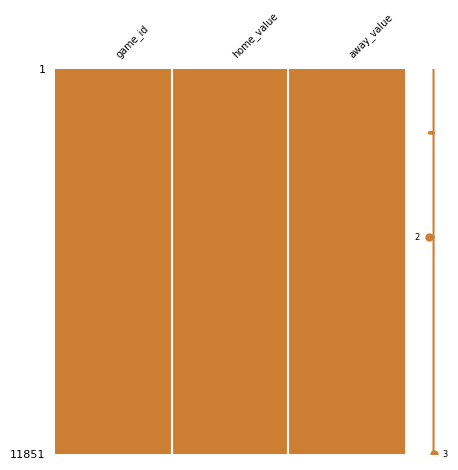

In [31]:
# 결측치 확인
null_check(club_value)

### games data

#### 데이터 확인

In [32]:
# 데이터 확인
games_data = games.drop(['competition_id', 'season', 'round', 'home_club_manager_name', 'away_club_manager_name', 'referee', 'attendance', 'url', 'stadium','home_club_position', 'away_club_position', 'home_club_name', 'away_club_name', 'aggregate', 'competition_type'], axis = 1).sort_values(by = 'date')
games_data

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_formation,away_club_formation
1009,3050427,2019-02-24,11,180,2,0,4-2-3-1,3-5-2
11598,3141118,2019-02-24,383,234,1,1,4-3-3 Defending,4-3-3 Defending
9019,3058613,2019-02-24,16,15,3,2,4-2-3-1,4-3-3 Attacking
2045,3141117,2019-02-24,1268,610,1,5,4-3-3 Defending,4-3-3 Defending
3388,3080818,2019-02-24,1244,1049,1,1,5-3-2,4-4-2 double 6
...,...,...,...,...,...,...,...,...
6843,4109512,2024-02-19,979,336,0,2,4-2-3-1,3-4-3
9414,4095322,2024-02-19,29,873,1,1,4-4-1-1,3-4-2-1
5941,4095251,2024-02-20,281,1148,1,0,4-1-4-1,3-5-2 flat
2471,4095336,2024-02-21,31,1031,4,1,4-3-3 Attacking,3-4-2-1


In [33]:
'4-3-3 Defending'.split(" ")[0]

'4-3-3'

In [34]:
def formation_preprocessing(dataset, column):

    club_formation = []
    
    for formation in dataset[column].values:
    
        formation = str(formation)
        
        if "Diamond" in formation:
            club_formation.append(formation.split(" ")[0] + "D")
            
        else:
            club_formation.append(formation.split(" ")[0])
    
    return club_formation

In [35]:
games_data['home_club_formation'] = formation_preprocessing(games_data, 'home_club_formation')
games_data['away_club_formation'] = formation_preprocessing(games_data, 'away_club_formation')

games_data.head(12)

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_formation,away_club_formation
1009,3050427,2019-02-24,11,180,2,0,4-2-3-1,3-5-2
11598,3141118,2019-02-24,383,234,1,1,4-3-3,4-3-3
9019,3058613,2019-02-24,16,15,3,2,4-2-3-1,4-3-3
2045,3141117,2019-02-24,1268,610,1,5,4-3-3,4-3-3
3388,3080818,2019-02-24,1244,1049,1,1,5-3-2,4-4-2
3387,3080814,2019-02-24,13,1050,2,0,4-4-2,5-3-2
2044,3081276,2019-02-24,430,46,3,3,4-1-4-1,4-2-3-1
6850,3081280,2019-02-24,6574,2722,1,1,3-4-3,4-4-2
7635,3080821,2019-02-24,366,150,0,2,4-4-2,3-4-2-1
10168,3080819,2019-02-24,3368,418,1,2,3-4-1-2,4-3-3


#### 데이터 eda

[ 결측치 확인 ]

-----------------------------------


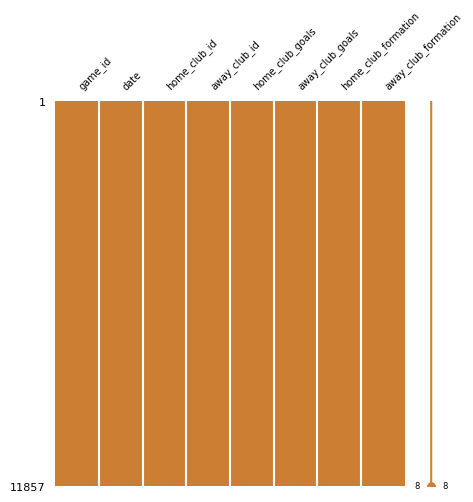

In [36]:
null_check(games_data)

### game event data

#### 데이터 확인

In [37]:
# 데이터 확인
events = game_events.drop(['game_event_id', 'minute', 'description', 'player_in_id'], axis = 1)
events = events[events['type'] != 'Substitutions']

assist = events.player_assist_id.mask(events.player_assist_id > 0, 'assist')

assist_temp = pd.DataFrame({'date' : events.date,
                       'game_id' : events.game_id,
                       'type' : assist,
                       'club_id' : events.club_id,
                       'player_id' : events.player_assist_id.values})
assist_data = assist_temp.dropna(axis = 0)

events_data = pd.concat((events.drop(['player_assist_id'], axis = 1), assist_data), ignore_index = True, sort = False)
events_data = events_data.sort_values(by = 'date')
events_data = events_data.reset_index(drop = True)

events_data

,date,game_id,type,club_id,player_id
0,2012-07-03,2231978,Goals,853,38004.0
1,2012-07-03,2231978,Goals,853,21679.0
2,2012-07-03,2231978,Goals,853,21679.0
3,2012-07-03,2231978,assist,853,79860.0
4,2012-07-03,2231978,assist,853,82883.0
...,...,...,...,...,...
289205,2024-02-22,4243719,Goals,273,266359.0
289206,2024-02-22,4243719,Goals,273,266359.0
289207,2024-02-22,4243719,Goals,5,357164.0
289208,2024-02-22,4243719,Cards,5,48859.0


In [38]:
events_data.type.unique()

array(['Goals', 'assist', 'Cards', 'Shootout'], dtype=object)

#### 데이터 eda

[ 결측치 확인 ]

-----------------------------------


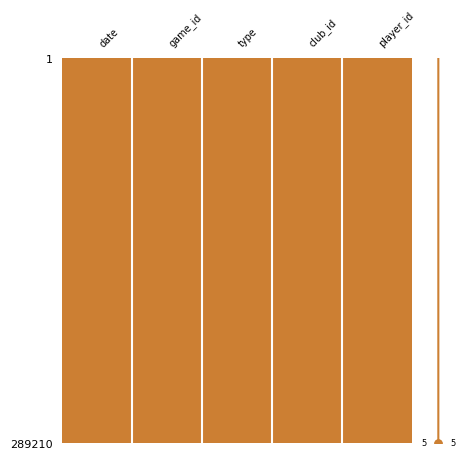

In [39]:
null_check(events_data)

### club games

#### 데이터 확인

In [40]:
club_games

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
0,2320450,1468,0,NaN,Holger Bachthaler,24,2,NaN,Armin Veh,Home,0
1,2320460,1,3,NaN,Jürgen Luginger,86,1,NaN,Robin Dutt,Home,1
2,2320472,2036,4,NaN,Frank Schmidt,72,5,NaN,Alexander Schmidt,Home,0
3,2321044,16,2,1.0,Jürgen Klopp,23,1,15.0,Torsten Lieberknecht,Home,1
4,2321060,23,0,18.0,Torsten Lieberknecht,24,2,11.0,Armin Veh,Home,0
...,...,...,...,...,...,...,...,...,...,...,...
133365,4095319,1148,2,14.0,Thomas Frank,543,0,11.0,Gary O'Neil,Away,1
133366,3219126,1010,1,17.0,Nigel Pearson,379,3,15.0,David Moyes,Away,0
133367,3098645,1177,3,NaN,Michael Hansen,5874,2,NaN,Tom Söjberg,Away,1
133368,3307741,36661,1,NaN,Aleksandr Gorshkov,32218,2,NaN,Viktor Antikhovich,Away,0


In [41]:
club_game_data = club_games[['game_id', 'club_id', 'hosting', 'is_win']]

club_game_home = club_game_data[club_game_data['hosting'] == 'Home'].drop(['hosting'], axis = 1)
club_game_home.columns = ['game_id', 'home_club_id', 'home_is_win']

club_game_away = club_game_data[club_game_data['hosting'] == 'Away'].drop(['hosting'], axis = 1)
club_game_away.columns = ['game_id', 'away_club_id', 'away_is_win']

club_game_data = pd.merge(club_game_home, club_game_away, on = "game_id")

win_lose_list = []

for i in range(len(club_game_data)):
    
    temp = club_game_data.iloc[ i , : ]
    temp_home_win = temp['home_is_win']
    temp_away_win = temp['away_is_win']

    if temp_home_win > temp_away_win:

        win_lose_list.append('home')

    elif temp_away_win > temp_home_win:

        win_lose_list.append('away')

    else:

        win_lose_list.append('draw')

club_game_data['result'] = win_lose_list
club_game_data = club_game_data[['game_id', 'home_club_id', 'away_club_id', 'result']]
club_game_data

,game_id,home_club_id,away_club_id,result
0,2320450,1468,24,away
1,2320460,1,86,home
2,2320472,2036,72,away
3,2321044,16,23,home
4,2321060,23,24,away
...,...,...,...,...
66680,4095319,543,1148,away
66681,3219126,379,1010,home
66682,3098645,5874,1177,away
66683,3307741,32218,36661,home


In [42]:
133370 / 2

66685.0

In [43]:
club_game_data['result'].unique()

array(['away', 'home', 'draw'], dtype=object)

#### 데이터 eda

[ 결측치 확인 ]

-----------------------------------


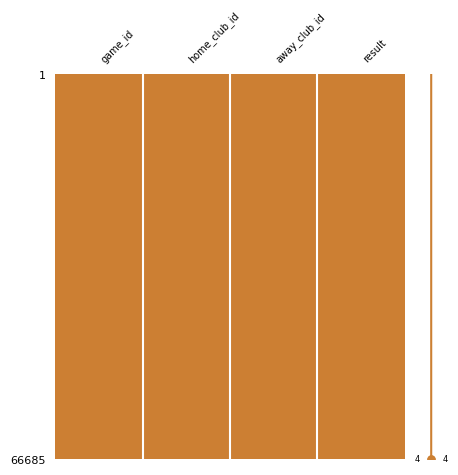

In [44]:
null_check(club_game_data)

## EDA for merged dataset

### merge

#### events data 준비

- events_data 에서 club_id가 현재 club이 아닌 게임 당시의 club으로 표시된 것인지 확인
    - 아래에서 동일한 선수(38004)에 대해 여러개의 club_id(4개)가 할당되어 있으므로 club_id 컬럼은 해당 date 또는 해당 game에서 뛰었던 선수의 그 당시 club을 나타내고 있음을 알 수 있다.

In [45]:
events_data

,date,game_id,type,club_id,player_id
0,2012-07-03,2231978,Goals,853,38004.0
1,2012-07-03,2231978,Goals,853,21679.0
2,2012-07-03,2231978,Goals,853,21679.0
3,2012-07-03,2231978,assist,853,79860.0
4,2012-07-03,2231978,assist,853,82883.0
...,...,...,...,...,...
289205,2024-02-22,4243719,Goals,273,266359.0
289206,2024-02-22,4243719,Goals,273,266359.0
289207,2024-02-22,4243719,Goals,5,357164.0
289208,2024-02-22,4243719,Cards,5,48859.0


In [46]:
events_data[events_data.player_id == 38004.0].club_id.unique()

array([853, 403, 202, 235], dtype=int64)

In [47]:
events_data.type.unique()

array(['Goals', 'assist', 'Cards', 'Shootout'], dtype=object)

In [48]:
events_data_temp = events_data.drop(['player_id'], axis = 1)

event_list = events_data_temp.type.unique()

for i in range(len(event_list)):
    temp_event = np.where(events_data_temp.type.values == event_list[i], 1, np.NaN)
    events_data_temp[event_list[i]] = temp_event

events_data_grouped_temp = events_data_temp.drop(['type'], axis = 1).groupby(['game_id', 'club_id', 'date']).count()
events_data_grouped = events_data_grouped_temp.reset_index().sort_values(by = 'date').set_index('date', drop = True)
events_data_grouped

,game_id,club_id,Goals,assist,Cards,Shootout
date,,,,,,
2012-07-03,2235764,5594,0,0,1,0
2012-07-03,2231982,28958,0,0,2,0
2012-07-03,2231982,6335,8,7,0,0
2012-07-03,2235764,1167,0,0,1,0
2012-07-03,2234412,10694,6,6,0,0
...,...,...,...,...,...,...
2024-02-22,4243719,5,2,1,2,0
2024-02-22,4243718,234,1,0,4,4
2024-02-22,4243718,12,1,1,3,5


In [49]:
# club 수 확인
len(events_data_grouped.club_id.unique())

2350

In [50]:
window = 3

events_dataset = pd.DataFrame({'game_id' : np.NaN,
                               'club_id' : np.NaN,
                               'Goals' : np.NaN,
                              'assist' : np.NaN,
                              'Cards' : np.NaN}, index = [0])
events_dataset.index.name = 'date'

club_list = events_data_grouped.club_id.unique()

# 각 event type에 대해 직전 5개 경기의 이동평균값으로 대체
for i in range(len(club_list)):
    
    temp_df_1 = events_data_grouped[events_data_grouped.club_id == club_list[i]]

    temp_df_2 = pd.DataFrame({'Goals' : temp_df_1.Goals,
                             'assist' : temp_df_1.assist,
                             'Cards' : temp_df_1.Cards})
    
    temp_df_shifted = temp_df_2.shift(axis = 0, fill_value = np.nan)
    
    temp_rolling = temp_df_shifted.rolling(window).mean()
    temp_df_3 = temp_df_1.drop(['Goals', 'assist', 'Cards', 'Shootout'], axis = 1)
    temp_finish = temp_df_3.join(temp_rolling, how = 'left')

    events_dataset = pd.concat((events_dataset, temp_finish), sort = False)
    
events_dataset = events_dataset.drop(index = 0).sort_values(by = 'date')
events_dataset

,game_id,club_id,Goals,assist,Cards
date,,,,,
2012-07-03,2235764.0,5594.0,NaN,NaN,NaN
2012-07-03,2234412.0,10694.0,NaN,NaN,NaN
2012-07-03,2231979.0,10532.0,NaN,NaN,NaN
2012-07-03,2231978.0,853.0,NaN,NaN,NaN
2012-07-03,2235764.0,1167.0,NaN,NaN,NaN
...,...,...,...,...,...
2024-02-22,4243721.0,452.0,1.333333,0.666667,2.666667
2024-02-22,4243720.0,60.0,1.333333,1.000000,2.000000
2024-02-22,4243724.0,141.0,2.666667,2.000000,2.000000


- 한계점: 위와 같이 처리할 경우 각 클럽의 맨 앞 5개 데이터는 NaN값으로 처리되며, 클럽 당 게임 수가 5이하인 클럽은 모두 NaN값으로 처리됨. 해당 NaN값들은 차후 전처리 필요

In [51]:
temp_club_count = pd.DataFrame(events_data_grouped.club_id.value_counts() < 6)
print("클럽 당 게임 수가 3 이하인 경우 : ", temp_club_count.value_counts())
print(temp_club_count)

클럽 당 게임 수가 3 이하인 경우 :  count
False    1221
True     1129
Name: count, dtype: int64
         count
club_id       
131      False
418      False
281      False
27       False
506      False
...        ...
4096      True
345       True
4113      True
21934     True
726       True

[2350 rows x 1 columns]


In [52]:
# club 수 확인
len(events_dataset.club_id.unique())

2350

#### game data 준비

In [53]:
games_data

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_formation,away_club_formation
1009,3050427,2019-02-24,11,180,2,0,4-2-3-1,3-5-2
11598,3141118,2019-02-24,383,234,1,1,4-3-3,4-3-3
9019,3058613,2019-02-24,16,15,3,2,4-2-3-1,4-3-3
2045,3141117,2019-02-24,1268,610,1,5,4-3-3,4-3-3
3388,3080818,2019-02-24,1244,1049,1,1,5-3-2,4-4-2
...,...,...,...,...,...,...,...,...
6843,4109512,2024-02-19,979,336,0,2,4-2-3-1,3-4-3
9414,4095322,2024-02-19,29,873,1,1,4-4-1-1,3-4-2-1
5941,4095251,2024-02-20,281,1148,1,0,4-1-4-1,3-5-2
2471,4095336,2024-02-21,31,1031,4,1,4-3-3,3-4-2-1


In [54]:
games_data.home_club_formation.isna().sum()

0

In [55]:
games_data.columns

Index(['game_id', 'date', 'home_club_id', 'away_club_id', 'home_club_goals',
       'away_club_goals', 'home_club_formation', 'away_club_formation'],
      dtype='object')

In [56]:
temp_home = games_data.drop(['away_club_id', 'away_club_goals', 'away_club_formation'], axis = 1)
temp_away = games_data.drop(['home_club_id', 'home_club_goals', 'home_club_formation'], axis = 1)

temp_home.columns = ['game_id', 'date', 'club_id', 'home_club_goals', 'home_club_formation']
temp_away.columns = ['game_id', 'date', 'club_id', 'away_club_goals', 'away_club_formation']

temp_home = pd.merge(temp_home, events_dataset, on = ["game_id", "club_id"], how = "left")
temp_away = pd.merge(temp_away, events_dataset, on = ["game_id", "club_id"], how = "left")

temp_home.columns = ['game_id', 'date', 'home_club_id', 'home_club_goals', 'home_club_formation', 'pre_home_goals', 'pre_home_assist', 'pre_home_cards']
temp_away.columns = ['game_id', 'date', 'away_club_id', 'away_club_goals', 'away_club_formation', 'pre_away_goals', 'pre_away_assist', 'pre_away_cards']

print(temp_home)
print(temp_away)

       game_id       date  home_club_id  home_club_goals home_club_formation  \
0      3050427 2019-02-24            11                2             4-2-3-1   
1      3141118 2019-02-24           383                1               4-3-3   
2      3058613 2019-02-24            16                3             4-2-3-1   
3      3141117 2019-02-24          1268                1               4-3-3   
4      3080818 2019-02-24          1244                1               5-3-2   
...        ...        ...           ...              ...                 ...   
11852  4109512 2024-02-19           979                0             4-2-3-1   
11853  4095322 2024-02-19            29                1             4-4-1-1   
11854  4095251 2024-02-20           281                1             4-1-4-1   
11855  4095336 2024-02-21            31                4               4-3-3   
11856  4103680 2024-02-22           416                0             3-4-1-2   

       pre_home_goals  pre_home_assist 

In [57]:
print("home club goals 결측치 수 : ", temp_home.home_club_goals.isna().sum())
print("away club goals 결측치 수 : ", temp_away.away_club_goals.isna().sum())

home club goals 결측치 수 :  0
away club goals 결측치 수 :  0


#### merge 1 [home / away team을 수평방향으로 나열]

In [191]:
dataset_merged = pd.merge(temp_home, temp_away, on = ["game_id", "date"], how = "left")
dataset_merged = pd.merge(dataset_merged, club_value, on = 'game_id', how = 'left')
dataset_merged = pd.merge(dataset_merged, club_game_data[['game_id', 'result']], on = 'game_id', how = 'left')

dataset_hori = dataset_merged
dataset_hori

,game_id,date,home_club_id,home_club_goals,home_club_formation,pre_home_goals,pre_home_assist,pre_home_cards,away_club_id,away_club_goals,away_club_formation,pre_away_goals,pre_away_assist,pre_away_cards,home_value,away_value,result
0,3050427,2019-02-24,11,2,4-2-3-1,2.000000,0.000000,0.000000,180,0,3-5-2,NaN,NaN,NaN,2.922222e+07,1.020588e+07,home
1,3141118,2019-02-24,383,1,4-3-3,3.000000,0.000000,0.000000,234,1,4-3-3,3.666667,0.000000,0.000000,8.200000e+06,3.638095e+06,draw
2,3058613,2019-02-24,16,3,4-2-3-1,2.333333,0.000000,0.000000,15,2,4-3-3,2.666667,0.000000,0.000000,2.427778e+07,1.849444e+07,home
3,3141117,2019-02-24,1268,1,4-3-3,1.666667,0.000000,0.000000,610,5,4-3-3,4.000000,0.000000,0.000000,8.486842e+05,1.789474e+07,away
4,3080818,2019-02-24,1244,1,5-3-2,2.333333,0.000000,0.000000,1049,1,4-4-2,1.666667,0.000000,0.000000,4.255556e+06,1.663889e+07,draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11852,4109512,2024-02-19,979,0,4-2-3-1,NaN,NaN,NaN,336,2,3-4-3,5.333333,4.000000,0.333333,7.400000e+05,1.427000e+07,away
11853,4095322,2024-02-19,29,1,4-4-1-1,0.666667,0.333333,2.333333,873,1,3-4-2-1,1.666667,1.000000,2.000000,1.507500e+07,1.107059e+07,draw
11854,4095251,2024-02-20,281,1,4-1-4-1,2.000000,1.666667,0.333333,1148,0,3-5-2,1.333333,1.000000,2.000000,5.566000e+07,1.290000e+07,home
11855,4095336,2024-02-21,31,4,4-3-3,2.666667,2.333333,2.666667,1031,1,3-4-2-1,2.000000,1.333333,1.666667,2.602647e+07,4.010526e+06,home


In [197]:
dataset_hori = dataset_hori.drop(['date', 'home_club_id', 'away_club_id'], axis = 1)

#### merge 2 [home / away team을 수직방향으로 나열]
- for 다중공선성 대응

In [192]:
new_columns = ['game_id', 'date', 'club_id', 'formations', 
               'pre_goals', 'pre_assit', 'pre_cards', 'club_value', 'result', 'home/away']

home_dataset = dataset_merged[['game_id', 'date', 'home_club_id',
                               'home_club_formation', 'pre_home_goals', 'pre_home_assist',
                               'pre_home_cards', 'home_value', 'result']]

away_dataset = dataset_merged[['game_id', 'date', 'away_club_id',
                               'away_club_formation', 'pre_away_goals', 'pre_away_assist',
                               'pre_away_cards', 'away_value', 'result']]

home = home_dataset.copy()
home['result'] = home['result'].apply(lambda x: 'win' if x == 'home' else 'lose' if x == 'away' else 'draw')
home['home/away'] = ['home'] * len(home)

away = away_dataset.copy()
away['result'] = away['result'].apply(lambda x: 'win' if x == 'home' else 'lose' if x == 'away' else 'draw')
away['home/away'] = ['away'] * len(away)

home.columns = new_columns
away.columns = new_columns

dataset_verti = pd.concat((home, away), ignore_index = True, sort = False)
dataset_verti

,game_id,date,club_id,formations,pre_goals,pre_assit,pre_cards,club_value,result,home/away
0,3050427,2019-02-24,11,4-2-3-1,2.000000,0.000000,0.000000,2.922222e+07,win,home
1,3141118,2019-02-24,383,4-3-3,3.000000,0.000000,0.000000,8.200000e+06,draw,home
2,3058613,2019-02-24,16,4-2-3-1,2.333333,0.000000,0.000000,2.427778e+07,win,home
3,3141117,2019-02-24,1268,4-3-3,1.666667,0.000000,0.000000,8.486842e+05,lose,home
4,3080818,2019-02-24,1244,5-3-2,2.333333,0.000000,0.000000,4.255556e+06,draw,home
...,...,...,...,...,...,...,...,...,...,...
23709,4109512,2024-02-19,336,3-4-3,5.333333,4.000000,0.333333,1.427000e+07,lose,away
23710,4095322,2024-02-19,873,3-4-2-1,1.666667,1.000000,2.000000,1.107059e+07,draw,away
23711,4095251,2024-02-20,1148,3-5-2,1.333333,1.000000,2.000000,1.290000e+07,win,away
23712,4095336,2024-02-21,1031,3-4-2-1,2.000000,1.333333,1.666667,4.010526e+06,win,away


In [196]:
dataset_verti = dataset_verti.drop(['date', 'club_id'], axis = 1)

#### merge 3 [home / away 차잇값 활용]

In [200]:
dataset_diff.columns

Index(['game_id', 'date', 'home_club_id', 'home_club_goals',
       'home_club_formation', 'pre_home_goals', 'pre_home_assist',
       'pre_home_cards', 'away_club_id', 'away_club_goals',
       'away_club_formation', 'pre_away_goals', 'pre_away_assist',
       'pre_away_cards', 'home_value', 'away_value', 'result',
       'pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff'],
      dtype='object')

In [202]:
dataset_diff = dataset_merged.copy()

dataset_diff['pre_goals_diff'] = dataset_diff['pre_home_goals'] - dataset_diff['pre_away_goals']
dataset_diff['pre_assist_diff'] = dataset_diff['pre_home_assist'] - dataset_diff['pre_away_assist']
dataset_diff['pre_cards_diff'] = dataset_diff['pre_home_cards'] - dataset_diff['pre_away_cards']
dataset_diff['value_diff'] = dataset_diff['home_value'] - dataset_diff['away_value']

dataset_diff = dataset_diff.drop(['home_club_goals', 'away_club_goals',
                                  'pre_home_goals', 'pre_home_assist', 'pre_home_cards', 'home_value',
                                   'pre_away_goals', 'pre_away_assist', 'pre_away_cards', 'away_value'], axis = 1)

dataset_diff

,game_id,date,home_club_id,home_club_formation,away_club_id,away_club_formation,result,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
0,3050427,2019-02-24,11,4-2-3-1,180,3-5-2,home,NaN,NaN,NaN,1.901634e+07
1,3141118,2019-02-24,383,4-3-3,234,4-3-3,draw,-0.666667,0.000000,0.000000,4.561905e+06
2,3058613,2019-02-24,16,4-2-3-1,15,4-3-3,home,-0.333333,0.000000,0.000000,5.783333e+06
3,3141117,2019-02-24,1268,4-3-3,610,4-3-3,away,-2.333333,0.000000,0.000000,-1.704605e+07
4,3080818,2019-02-24,1244,5-3-2,1049,4-4-2,draw,0.666667,0.000000,0.000000,-1.238333e+07
...,...,...,...,...,...,...,...,...,...,...,...
11852,4109512,2024-02-19,979,4-2-3-1,336,3-4-3,away,NaN,NaN,NaN,-1.353000e+07
11853,4095322,2024-02-19,29,4-4-1-1,873,3-4-2-1,draw,-1.000000,-0.666667,0.333333,4.004412e+06
11854,4095251,2024-02-20,281,4-1-4-1,1148,3-5-2,home,0.666667,0.666667,-1.666667,4.276000e+07
11855,4095336,2024-02-21,31,4-3-3,1031,3-4-2-1,home,0.666667,1.000000,1.000000,2.201594e+07


In [203]:
dataset_diff = dataset_diff.drop(['date', 'home_club_id', 'away_club_id'], axis = 1)

### 사용할 데이터셋 설정

In [209]:
dataset = dataset_diff

### 결측치 확인

[ 결측치 확인 ]

-----------------------------------
pre_goals_diff 결측치 비율:
41.19 %
-----------------------------------
pre_assist_diff 결측치 비율:
41.19 %
-----------------------------------
pre_cards_diff 결측치 비율:
41.19 %
-----------------------------------
value_diff 결측치 비율:
0.08 %
-----------------------------------


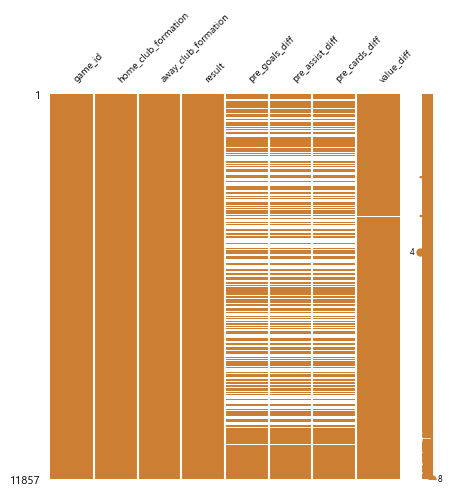

In [210]:
null_check(dataset)

### 범주형자료

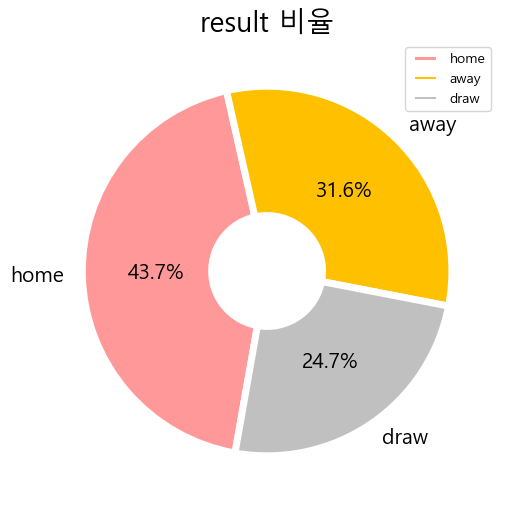

In [211]:
pie(dataset.result)

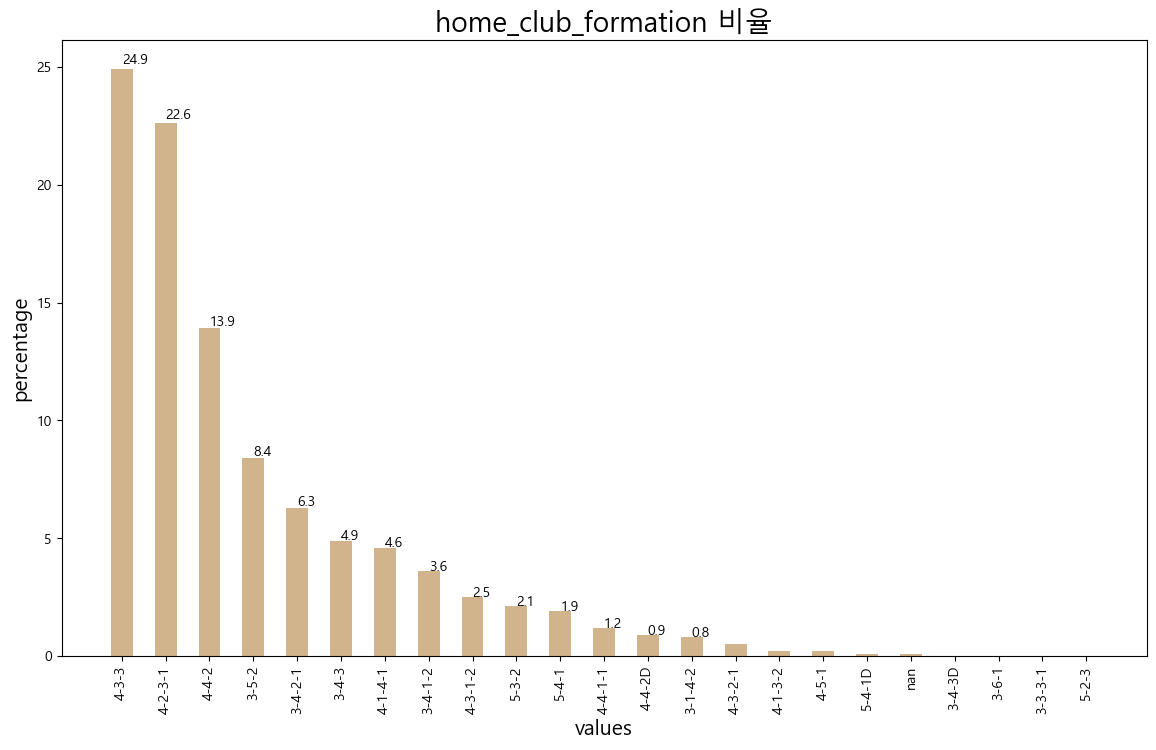

In [212]:
bar(dataset.home_club_formation)

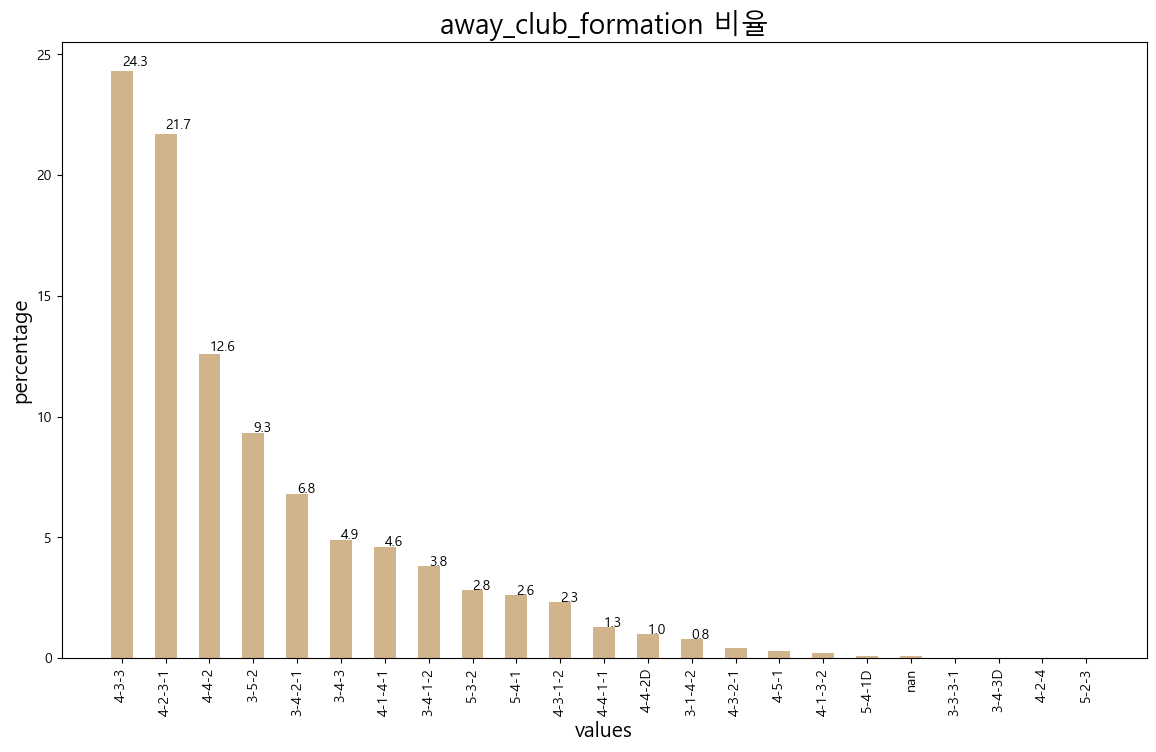

In [213]:
bar(dataset.away_club_formation)

### 수치형 자료

#### 정규성

In [215]:
dataset.columns

Index(['game_id', 'home_club_formation', 'away_club_formation', 'result',
       'pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff', 'value_diff'],
      dtype='object')

In [216]:
column_list = ['pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff', 'value_diff']
norm_check(dataset, column_list, 'shapiro')

[column별 샤피로 윌크 검정]
(H0 : 데이터가 정규분포를 따름)

----------------------------------------

pre_goals_diff 검정
샤피로-윌크 검정 통계량: 0.9846550226211548
p-값: 7.921296705598236e-27

----------------------------------------

pre_assist_diff 검정
샤피로-윌크 검정 통계량: 0.5216116309165955
p-값: 0.0

----------------------------------------

pre_cards_diff 검정
샤피로-윌크 검정 통계량: 0.5425527691841125
p-값: 0.0

----------------------------------------

value_diff 검정
샤피로-윌크 검정 통계량: 0.9381911754608154
p-값: 0.0



C:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [217]:
norm_check(dataset, column_list, 'anderson')

[column별 앤더슨 달링 검정]
(H0 : 데이터가 정규분포를 따름)

----------------------------------------

pre_goals_diff 검정
앤더슨-달링 검정 통계량: 40.71814385739344
5% 임계값: 0.787

----------------------------------------

pre_assist_diff 검정
앤더슨-달링 검정 통계량: 1520.2746224210478
5% 임계값: 0.787

----------------------------------------

pre_cards_diff 검정
앤더슨-달링 검정 통계량: 1475.414222591664
5% 임계값: 0.787

----------------------------------------

value_diff 검정
앤더슨-달링 검정 통계량: 290.28796117460297
5% 임계값: 0.787



C:\Users\USER\AppData\Local\Temp\ipykernel_18984\1695640615.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, kde = True, fit=norm)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


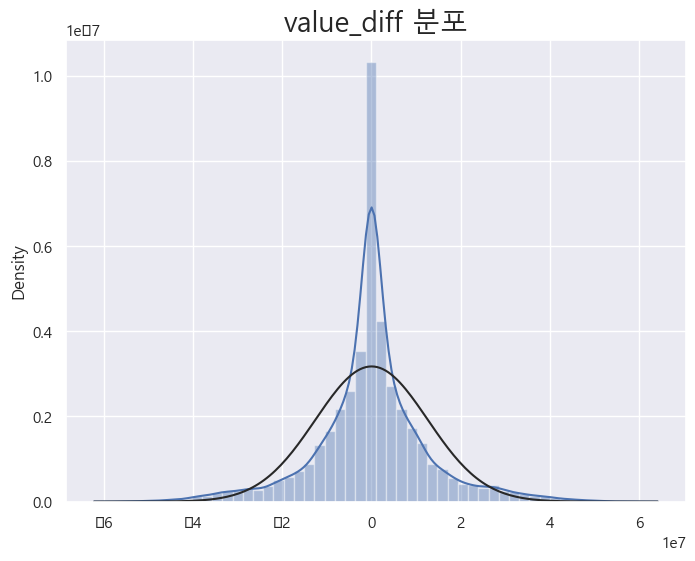

In [218]:
dist(dataset['value_diff']);

C:\Users\USER\AppData\Local\Temp\ipykernel_18984\1695640615.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, kde = True, fit=norm)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


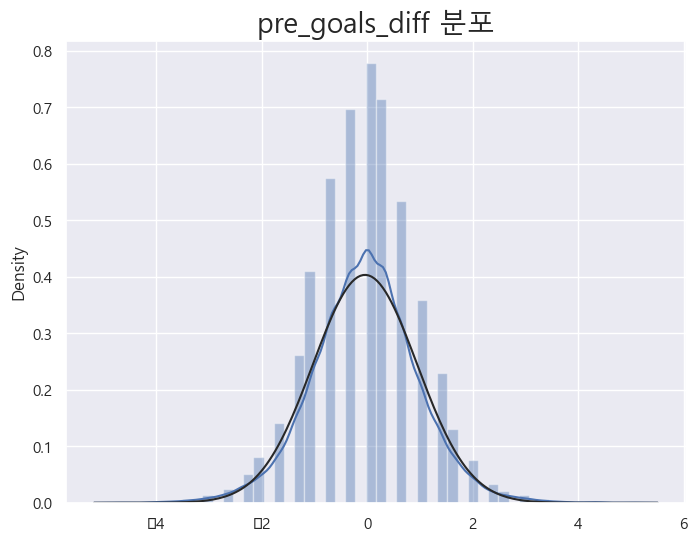

In [219]:
dist(dataset['pre_goals_diff']);

#### 이상치

In [220]:
dataset.columns

Index(['game_id', 'home_club_formation', 'away_club_formation', 'result',
       'pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff', 'value_diff'],
      dtype='object')

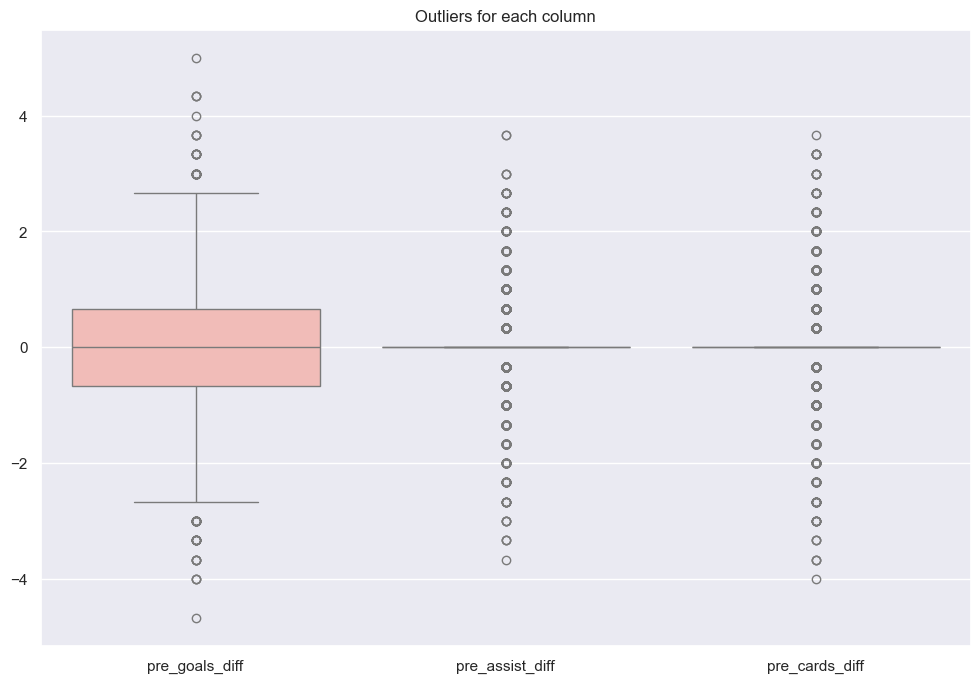

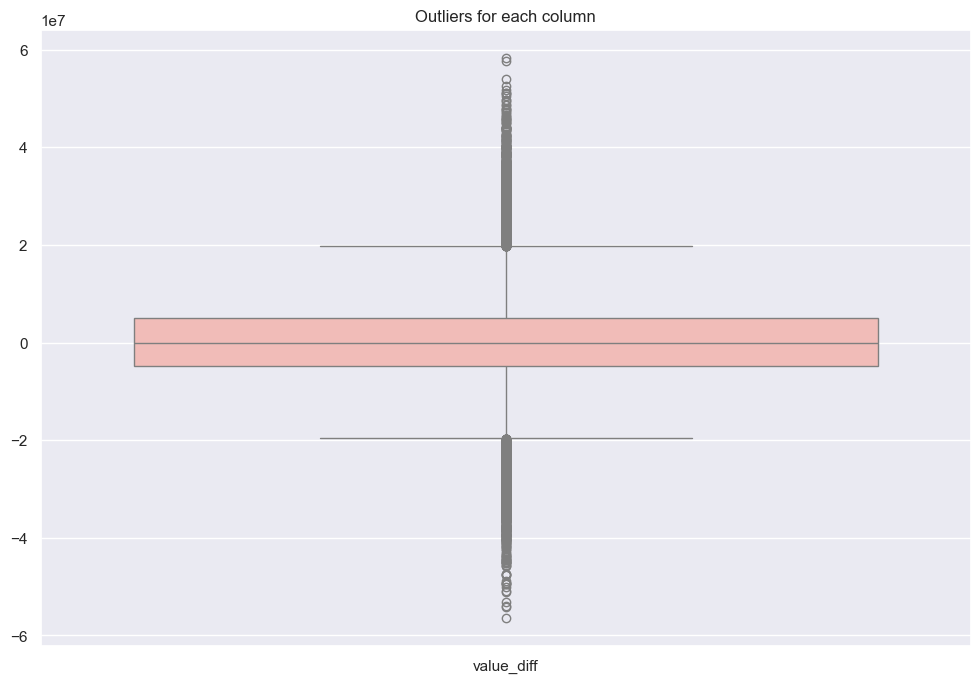

In [252]:
eda_dataset = dataset[['pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff', 'value_diff']]
eda_dataset_1 = eda_dataset[['pre_goals_diff', 'pre_assist_diff', 'pre_cards_diff']]
eda_dataset_2 = eda_dataset[['value_diff']]
outlier(eda_dataset_1)
outlier(eda_dataset_2)

#### 상관관계

In [253]:
eda_dataset = eda_dataset.dropna()
eda_dataset

,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
1,-0.666667,0.000000,0.000000,4.561905e+06
2,-0.333333,0.000000,0.000000,5.783333e+06
3,-2.333333,0.000000,0.000000,-1.704605e+07
4,0.666667,0.000000,0.000000,-1.238333e+07
6,1.666667,0.000000,0.000000,-9.481250e+06
...,...,...,...,...
11851,1.333333,1.000000,0.000000,2.554348e+05
11853,-1.000000,-0.666667,0.333333,4.004412e+06
11854,0.666667,0.666667,-1.666667,4.276000e+07
11855,0.666667,1.000000,1.000000,2.201594e+07


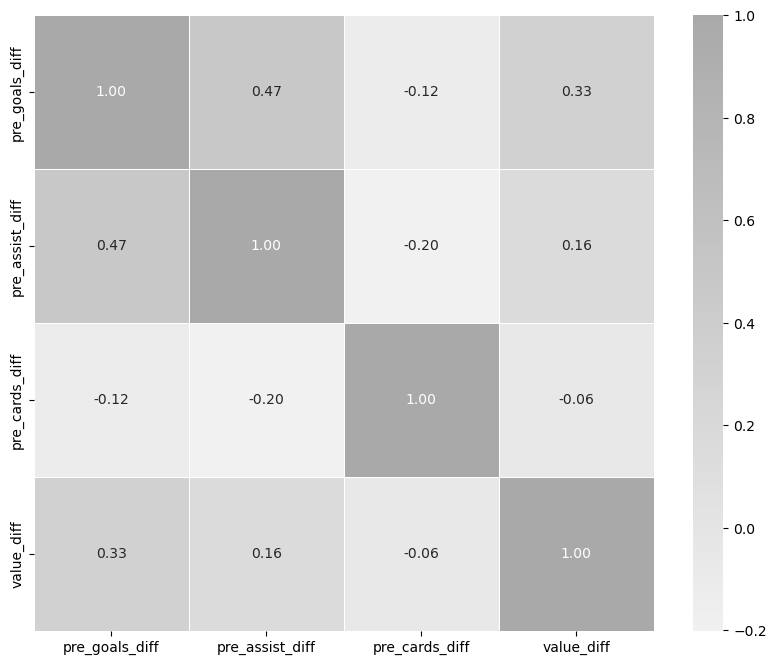

In [254]:
plt.rcdefaults()
plt.figure(figsize=(10,8))
cmap = sns.light_palette("darkgray", as_cmap = True)
sns.heatmap(data = eda_dataset.corr(), annot = True, fmt = '.2f', linewidths = .5, cmap = cmap)
plt.show()

In [223]:
eda_dataset_corr = eda_dataset.corr(method='pearson')
eda_dataset_corr.style.background_gradient(cmap = cmap).format('{:.2f}')

,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
pre_goals_diff,1.00,0.47,-0.12,0.33
pre_assist_diff,0.47,1.00,-0.20,0.16
pre_cards_diff,-0.12,-0.20,1.00,-0.06
value_diff,0.33,0.16,-0.06,1.00


#### 다중공선성

In [224]:
eda_dataset.shape

(6967, 4)

In [225]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(eda_dataset.values, i) for i in range(eda_dataset.shape[1])]
vif["features"] = eda_dataset.columns
vif

,VIF Factor,features
0,1.399323,pre_goals_diff
1,1.319277,pre_assist_diff
2,1.044059,pre_cards_diff
3,1.119112,value_diff


#### pairplot

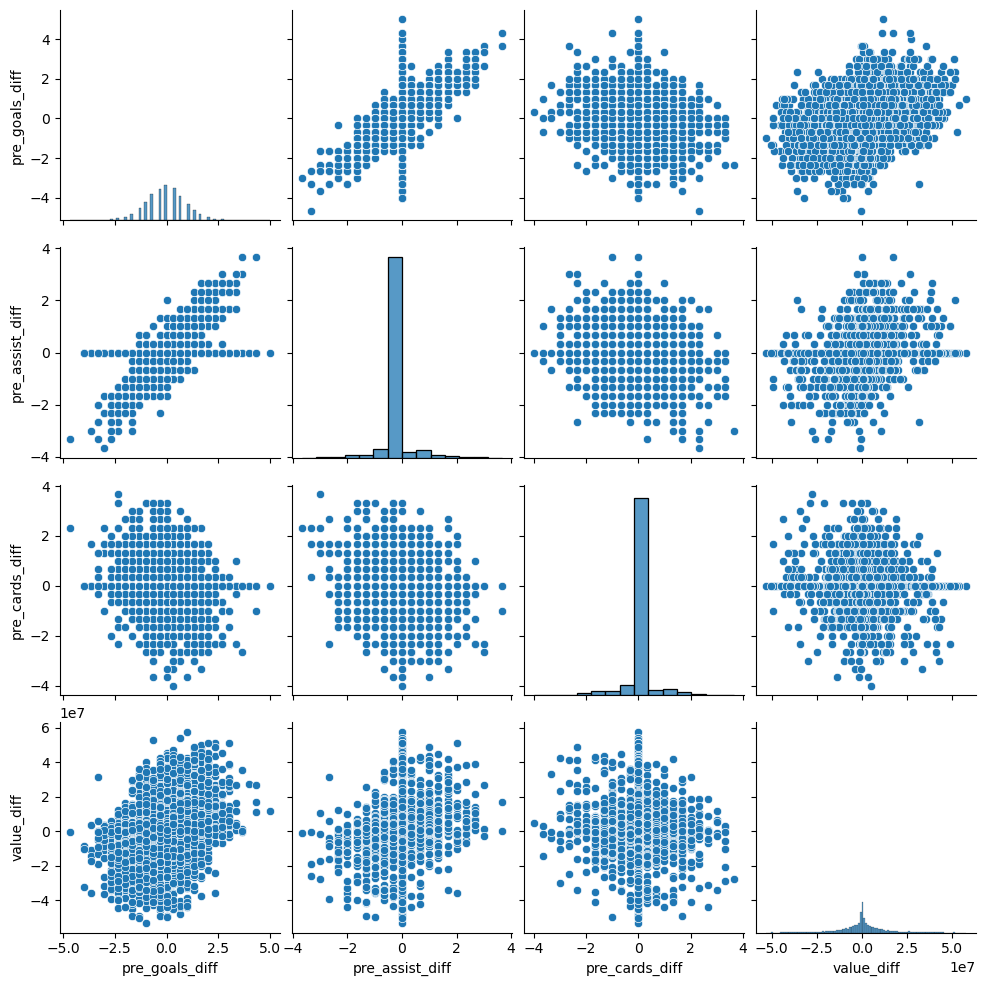

In [227]:
sns.pairplot(eda_dataset)
plt.show();

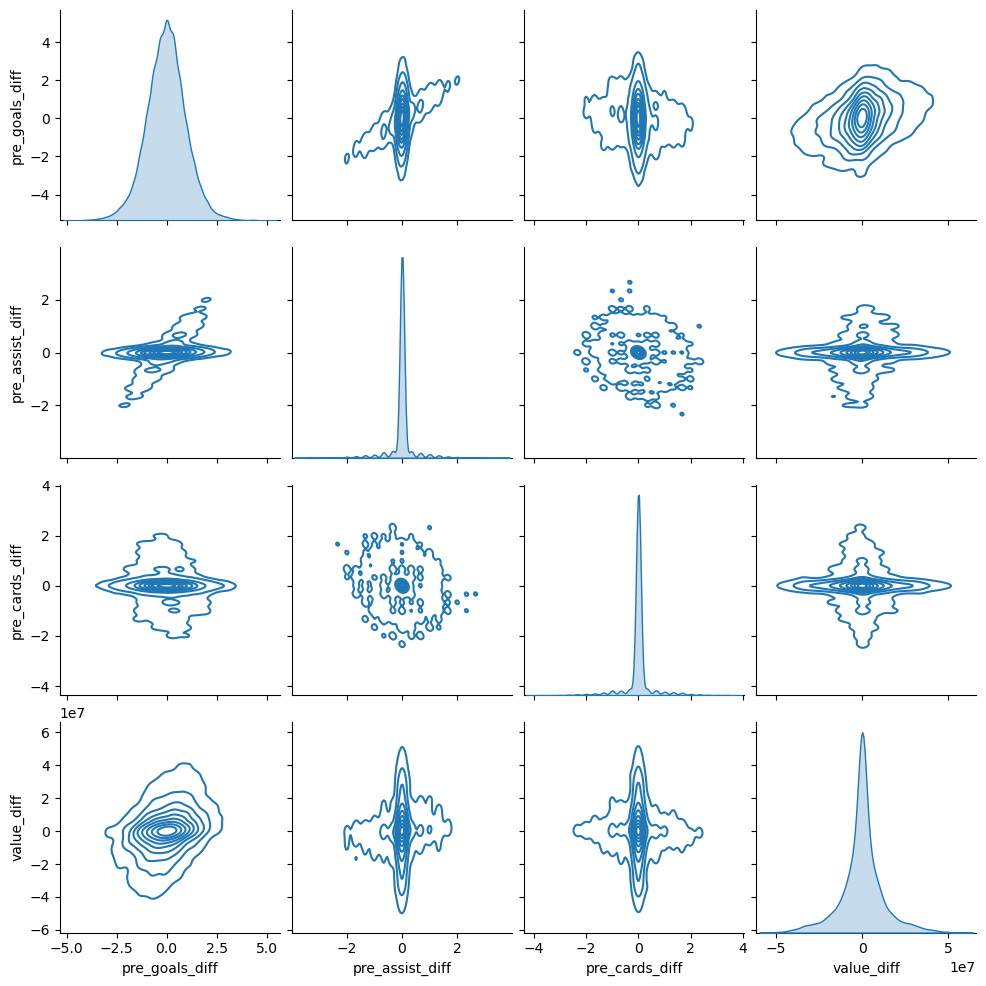

In [229]:
sns.pairplot(eda_dataset, kind = 'kde')
plt.show();

# PREPROCESSING

## 범주형 변수 처리

- label encoding 수행

In [255]:
dataset

,game_id,home_club_formation,away_club_formation,result,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
0,3050427,4-2-3-1,3-5-2,home,NaN,NaN,NaN,1.901634e+07
1,3141118,4-3-3,4-3-3,draw,-0.666667,0.000000,0.000000,4.561905e+06
2,3058613,4-2-3-1,4-3-3,home,-0.333333,0.000000,0.000000,5.783333e+06
3,3141117,4-3-3,4-3-3,away,-2.333333,0.000000,0.000000,-1.704605e+07
4,3080818,5-3-2,4-4-2,draw,0.666667,0.000000,0.000000,-1.238333e+07
...,...,...,...,...,...,...,...,...
11852,4109512,4-2-3-1,3-4-3,away,NaN,NaN,NaN,-1.353000e+07
11853,4095322,4-4-1-1,3-4-2-1,draw,-1.000000,-0.666667,0.333333,4.004412e+06
11854,4095251,4-1-4-1,3-5-2,home,0.666667,0.666667,-1.666667,4.276000e+07
11855,4095336,4-3-3,3-4-2-1,home,0.666667,1.000000,1.000000,2.201594e+07


In [256]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

dataset_encoded = dataset.copy()

dataset_encoded['home_club_formation'] = encoder.fit_transform(dataset_encoded['home_club_formation'].values)
dataset_encoded['away_club_formation'] = encoder.fit_transform(dataset_encoded['away_club_formation'].values)
dataset_encoded['result'] = encoder.fit_transform(dataset_encoded['result'].values)

display(encoder.classes_)

array(['away', 'draw', 'home'], dtype=object)

In [257]:
dataset_encoded

,game_id,home_club_formation,away_club_formation,result,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
0,3050427,10,6,2,NaN,NaN,NaN,1.901634e+07
1,3141118,13,13,1,-0.666667,0.000000,0.000000,4.561905e+06
2,3058613,10,13,2,-0.333333,0.000000,0.000000,5.783333e+06
3,3141117,13,13,0,-2.333333,0.000000,0.000000,-1.704605e+07
4,3080818,19,15,1,0.666667,0.000000,0.000000,-1.238333e+07
...,...,...,...,...,...,...,...,...
11852,4109512,10,4,0,NaN,NaN,NaN,-1.353000e+07
11853,4095322,14,3,1,-1.000000,-0.666667,0.333333,4.004412e+06
11854,4095251,9,6,2,0.666667,0.666667,-1.666667,4.276000e+07
11855,4095336,13,3,2,0.666667,1.000000,1.000000,2.201594e+07


## 결측치 처리

### MICE

In [78]:
pip install impyute

Note: you may need to restart the kernel to use updated packages.


In [233]:
from impyute.imputation.cs import mice # iterativeimputer로 변경됨
from sklearn.experimental import enable_iterative_imputer
# we need to import enable_iterative_imputer 
# which is like a switch so that scikit-learn knows that 
# we want to use the experimental version of Iterative Imputer
from sklearn.impute import IterativeImputer

In [258]:
dataset_imputed = pd.DataFrame(IterativeImputer(max_iter = 10, random_state=2077).fit_transform(dataset_encoded))
dataset_imputed.columns = dataset_encoded.columns
dataset_imputed = dataset_imputed.set_index('game_id', drop = True)
dataset_imputed

,home_club_formation,away_club_formation,result,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,,
3050427.0,10.0,6.0,2.0,0.376860,0.107064,-0.041173,1.901634e+07
3141118.0,13.0,13.0,1.0,-0.666667,0.000000,0.000000,4.561905e+06
3058613.0,10.0,13.0,2.0,-0.333333,0.000000,0.000000,5.783333e+06
3141117.0,13.0,13.0,0.0,-2.333333,0.000000,0.000000,-1.704605e+07
3080818.0,19.0,15.0,1.0,0.666667,0.000000,0.000000,-1.238333e+07
...,...,...,...,...,...,...,...
4109512.0,10.0,4.0,0.0,-0.366884,-0.106218,0.031191,-1.353000e+07
4095322.0,14.0,3.0,1.0,-1.000000,-0.666667,0.333333,4.004412e+06
4095251.0,9.0,6.0,2.0,0.666667,0.666667,-1.666667,4.276000e+07


[ 결측치 확인 ]

-----------------------------------


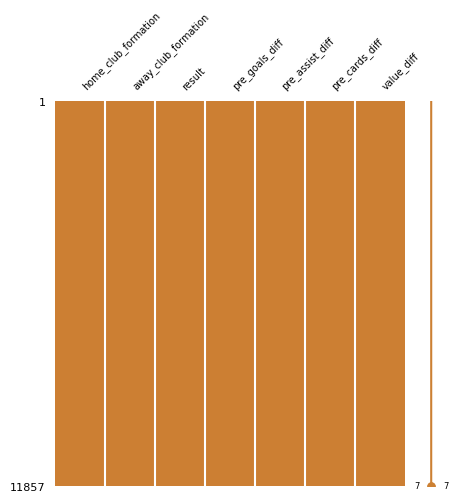

In [237]:
null_check(dataset_imputed)

### KNN

In [85]:
from sklearn.impute import KNNImputer

In [238]:
imputer = KNNImputer(n_neighbors = 3)
dataset_imputed = imputer.fit_transform(dataset_encoded)
dataset_imputed = pd.DataFrame(dataset_imputed)
dataset_imputed.columns = dataset_encoded.columns
dataset_imputed = dataset_imputed.set_index('game_id', drop = True)
dataset_imputed

,home_club_formation,away_club_formation,result,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,,
3050427.0,10.0,6.0,2.0,0.888889,0.000000,0.000000,1.901634e+07
3141118.0,13.0,13.0,1.0,-0.666667,0.000000,0.000000,4.561905e+06
3058613.0,10.0,13.0,2.0,-0.333333,0.000000,0.000000,5.783333e+06
3141117.0,13.0,13.0,0.0,-2.333333,0.000000,0.000000,-1.704605e+07
3080818.0,19.0,15.0,1.0,0.666667,0.000000,0.000000,-1.238333e+07
...,...,...,...,...,...,...,...
4109512.0,10.0,4.0,0.0,0.111111,0.000000,0.333333,-1.353000e+07
4095322.0,14.0,3.0,1.0,-1.000000,-0.666667,0.333333,4.004412e+06
4095251.0,9.0,6.0,2.0,0.666667,0.666667,-1.666667,4.276000e+07


[ 결측치 확인 ]

-----------------------------------


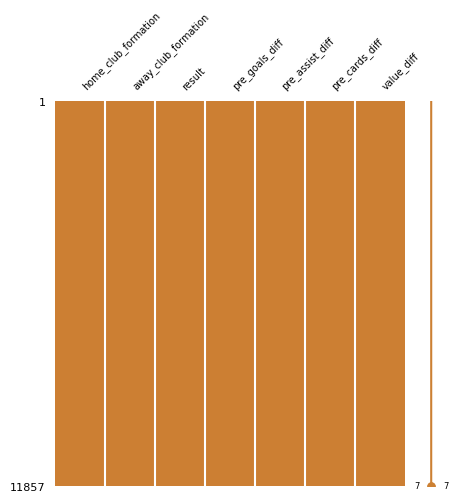

In [241]:
null_check(dataset_imputed)

## 데이터 스플릿

In [259]:
from sklearn.model_selection import train_test_split

dataset_preprocessed = dataset_imputed

x = dataset_preprocessed.drop(['result'], axis = 1)
y = dataset_preprocessed['result']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=2077, stratify = y)
# stratify는 데이터 클래스의 비율을 일정한 수준으로 유지한채 데이터를 스플릿하는 함수임

In [244]:
x_train

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3216177.0,13.0,13.0,-0.106494,-0.023878,0.008637,-3.770833e+05
3838058.0,15.0,15.0,0.342369,0.088464,-0.046303,1.685237e+07
3598020.0,13.0,6.0,0.333333,0.000000,0.000000,1.414286e+06
3212633.0,9.0,8.0,0.333333,0.000000,0.000000,8.500000e+05
3597809.0,13.0,13.0,-0.041431,-0.004119,-0.001201,-1.384569e+05
...,...,...,...,...,...,...
3141189.0,10.0,13.0,-0.045372,0.002792,0.002530,-4.877632e+05
3412875.0,10.0,15.0,1.000000,0.000000,0.000000,1.492250e+07
3597991.0,13.0,13.0,0.020881,0.024594,-0.006643,-9.250000e+04


In [260]:
y_train

game_id
3216177.0    0.0
3838058.0    2.0
3598020.0    2.0
3212633.0    1.0
3597809.0    1.0
            ... 
3141189.0    1.0
3412875.0    2.0
3597991.0    2.0
3614754.0    1.0
3229543.0    1.0
Name: result, Length: 8299, dtype: float64

## 스케일링

### Robust Scaler

In [250]:
x_train

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3216177.0,13.0,13.0,-0.106494,-0.023878,0.008637,-3.770833e+05
3838058.0,15.0,15.0,0.342369,0.088464,-0.046303,1.685237e+07
3598020.0,13.0,6.0,0.333333,0.000000,0.000000,1.414286e+06
3212633.0,9.0,8.0,0.333333,0.000000,0.000000,8.500000e+05
3597809.0,13.0,13.0,-0.041431,-0.004119,-0.001201,-1.384569e+05
...,...,...,...,...,...,...
3141189.0,10.0,13.0,-0.045372,0.002792,0.002530,-4.877632e+05
3412875.0,10.0,15.0,1.000000,0.000000,0.000000,1.492250e+07
3597991.0,13.0,13.0,0.020881,0.024594,-0.006643,-9.250000e+04


In [261]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(train_data, test_data, scale_column_list, category_column_list):

    scaler = RobustScaler()
    temp_scale_train = train_data[scale_column_list]
    temp_scale_test = test_data[scale_column_list]
    
    scaler.fit(temp_scale_train) # x_train 데이터를 fitting 함

    # train data 적용
    scaled_x_train = pd.DataFrame(data = scaler.transform(temp_scale_train), columns = scale_column_list)
    scaled_x_train = scaled_x_train.set_index(train_data.index)
    scaled_x_train = scaled_x_train.join(train_data[category_column_list], how = 'left')

    # test data 적용
    scaled_x_test = pd.DataFrame(data = scaler.transform(temp_scale_test), columns = scale_column_list)
    scaled_x_test = scaled_x_test.set_index(test_data.index)
    scaled_x_test = scaled_x_test.join(test_data[category_column_list], how = 'left')

    return scaled_x_train, scaled_x_test

In [270]:
scale_columns = ['pre_goals_diff', 'pre_assist_diff', 
                 'pre_cards_diff', 'value_diff']

category_columns = ['home_club_formation', 'away_club_formation']

scaled_x_train, scaled_x_test = robust_scaling(x_train, x_test, scale_columns, category_columns)

In [271]:
scaled_x_train = scaled_x_train[['home_club_formation', 'away_club_formation',
                                 'pre_goals_diff', 'pre_assist_diff', 
                                 'pre_cards_diff', 'value_diff']]
scaled_x_train

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3216177.0,13.0,13.0,-0.159742,-4.741682,2.948121,-0.040403
3838058.0,15.0,15.0,0.513554,17.567073,-15.805752,1.742235
3598020.0,13.0,6.0,0.500000,0.000000,0.000000,0.144940
3212633.0,9.0,8.0,0.500000,0.000000,0.000000,0.086556
3597809.0,13.0,13.0,-0.062147,-0.818025,-0.410006,-0.015714
...,...,...,...,...,...,...
3141189.0,10.0,13.0,-0.068059,0.554391,0.863606,-0.051855
3412875.0,10.0,15.0,1.500000,0.000000,0.000000,1.542562
3597991.0,13.0,13.0,0.031322,4.883858,-2.267681,-0.010959


In [272]:
scaled_x_test = scaled_x_test[['home_club_formation', 'away_club_formation',
                               'pre_goals_diff', 'pre_assist_diff', 
                            'pre_cards_diff', 'value_diff']]
scaled_x_test

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3211802.0,9.0,15.0,0.500000,0.000000,0.000000,0.116159
3588221.0,2.0,9.0,0.586099,17.362911,-18.416576,2.005595
3837388.0,4.0,2.0,-0.500000,0.000000,0.000000,0.126498
3450985.0,15.0,15.0,-1.500000,0.000000,0.000000,-2.751148
3229220.0,13.0,6.0,-1.000000,0.000000,0.000000,1.209147
...,...,...,...,...,...,...
3844981.0,3.0,6.0,-0.059902,-1.616779,-1.676336,-0.322729
4112815.0,13.0,14.0,-2.500000,-264.771664,682.703437,-0.617339
3451401.0,15.0,15.0,1.000000,0.000000,0.000000,-0.216516


### MinMax Scaler

In [96]:
from sklearn.preprocessing import MinMaxScaler

def minmax_scaling(train_data, test_data, scale_column_list, category_column_list):

    scaler = MinMaxScaler()
    temp_scale_train = train_data[scale_column_list]
    temp_scale_test = test_data[scale_column_list]
    
    scaler.fit(temp_scale_train) # x_train 데이터를 fitting 함

    # train data 적용
    scaled_x_train = pd.DataFrame(data = scaler.transform(temp_scale_train), columns = scale_column_list)
    scaled_x_train = scaled_x_train.set_index(train_data.index)
    scaled_x_train = scaled_x_train.join(train_data[category_column_list], how = 'left')

    # test data 적용
    scaled_x_test = pd.DataFrame(data = scaler.transform(temp_scale_test), columns = scale_column_list)
    scaled_x_test = scaled_x_test.set_index(test_data.index)
    scaled_x_test = scaled_x_test.join(test_data[category_column_list], how = 'left')

    return scaled_x_train, scaled_x_test

In [267]:
scale_columns = ['pre_goals_diff', 'pre_assist_diff', 
                 'pre_cards_diff', 'value_diff']

category_columns = ['home_club_formation', 'away_club_formation']

scaled_x_train, scaled_x_test = minmax_scaling(x_train, x_test, scale_columns, category_columns)

In [268]:
scaled_x_train = scaled_x_train[['home_club_formation', 'away_club_formation',
                                 'pre_goals_diff', 'pre_assist_diff', 
                                 'pre_cards_diff', 'value_diff']]
scaled_x_train

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3216177.0,13.0,13.0,0.506686,0.496744,0.501178,0.517507
3838058.0,15.0,15.0,0.556560,0.512063,0.493686,0.676804
3598020.0,13.0,6.0,0.555556,0.500000,0.500000,0.534069
3212633.0,9.0,8.0,0.555556,0.500000,0.500000,0.528852
3597809.0,13.0,13.0,0.513915,0.499438,0.499836,0.519713
...,...,...,...,...,...,...
3141189.0,10.0,13.0,0.513477,0.500381,0.500345,0.516483
3412875.0,10.0,15.0,0.629630,0.500000,0.500000,0.658961
3597991.0,13.0,13.0,0.520839,0.503354,0.499094,0.520138


In [269]:
scaled_x_test = scaled_x_test[['home_club_formation', 'away_club_formation',
                               'pre_goals_diff', 'pre_assist_diff', 
                            'pre_cards_diff', 'value_diff']]
scaled_x_test

,home_club_formation,away_club_formation,pre_goals_diff,pre_assist_diff,pre_cards_diff,value_diff
game_id,,,,,,
3211802.0,9.0,15.0,0.555556,0.500000,0.500000,0.531497
3588221.0,2.0,9.0,0.561933,0.511923,0.492643,0.700338
3837388.0,4.0,2.0,0.481481,0.500000,0.500000,0.532421
3450985.0,15.0,15.0,0.407407,0.500000,0.500000,0.275273
3229220.0,13.0,6.0,0.444444,0.500000,0.500000,0.629167
...,...,...,...,...,...,...
3844981.0,3.0,6.0,0.514081,0.498890,0.499330,0.492278
4112815.0,13.0,14.0,0.333333,0.318182,0.772727,0.465951
3451401.0,15.0,15.0,0.592593,0.500000,0.500000,0.501769


# MODELING

## Gradient Boosting

### modeling

In [413]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 2, random_state = 2077)
gb_model.fit(scaled_x_train, y_train.ravel())
gb_predict_proba = gb_model.predict_proba(scaled_x_test)
gb_prediction = gb_model.predict(scaled_x_test)
gb_score = gb_model.score(scaled_x_test, y_test)

### 평가

In [417]:
def round_f(score):
    rounded_score = round(score, ndigits = 3)
    return rounded_score

#### accuracy score

In [418]:
gb_score = round_f(gb_score)
gb_score

0.636

In [419]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

gb_acc_score = accuracy_score(y_test, gb_prediction)
gb_acc_score = round_f(gb_acc_score)
gb_acc_score

0.636

#### F1 score

In [421]:
from sklearn.metrics import f1_score

gb_f1_score = f1_score(y_test, gb_prediction, average = 'weighted')
gb_f1_score = round_f(gb_f1_score)
gb_f1_score

0.628

### visualization

#### confusion matrix

In [422]:
confusion_matrix = confusion_matrix(y_true = y_test, y_pred = gb_prediction)

con_mat = confusion_matrix
accuracy = (con_mat[0,0] + con_mat[1,1] + con_mat[2,2])/len(y_test)
accuracy = round_f(accuracy)
print('accuracy =', accuracy)

accuracy = 0.636


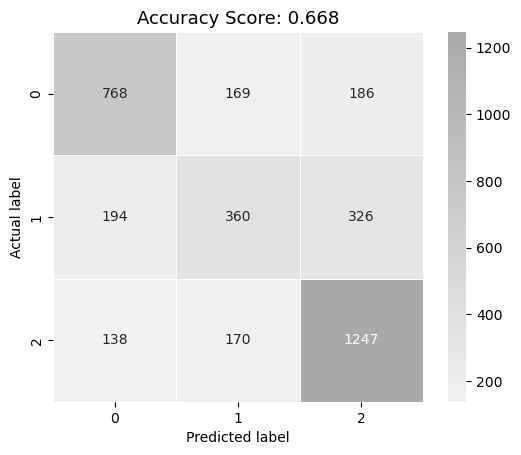

In [474]:
cmap = sns.light_palette("darkgray", as_cmap = True)

sns.heatmap(confusion_matrix, annot = True, fmt = '.0f', cmap = cmap, square = True, linewidths = 0.5)
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
title = 'Accuracy Score: {0}'.format(accuracy) 
plt.title(title, size = 13) 
plt.show()

#### feature importance

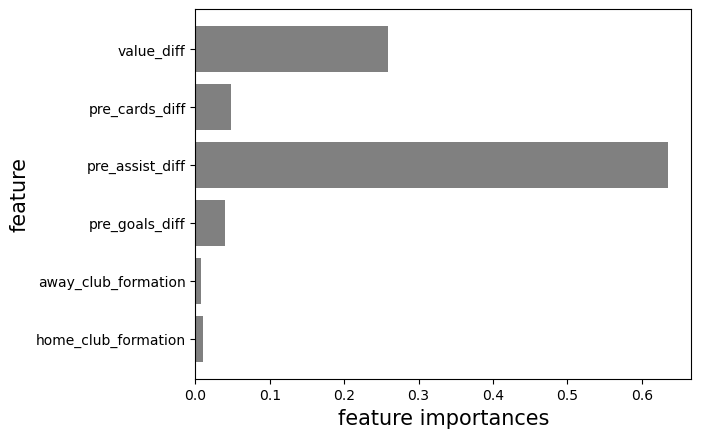

In [480]:
n_feature = x_train.shape[1]
index=np.arange(n_feature)

plt.barh(index, gb_model.feature_importances_, align = 'center', color = 'grey')
plt.yticks(index, x_train.columns)
plt.xlabel('feature importances', size=15)
plt.ylabel('feature', size=15)
plt.show() 

## Logistic Regression

### modeling

In [279]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(solver = 'saga', max_iter=7500, multi_class = 'multinomial')
# logistic_model = LogisticRegression(solver = 'lbfgs', max_iter=7500, multi_class = 'multinomial')
logistic_model.fit(scaled_x_train, y_train.ravel())
logistic_predict_proba = logistic_model.predict_proba(scaled_x_test)
logistic_prediction = logistic_model.predict(scaled_x_test)
logistic_score = logistic_model.score(scaled_x_test, y_test)

### 평가

#### accuracy score

In [424]:
logistic_score = round_f(logistic_score)
logistic_score

0.522

In [425]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

logistic_acc_score = accuracy_score(y_test, logistic_prediction)
logistic_acc_score = round_f(logistic_acc_score)
logistic_acc_score

0.522

#### F1 score

In [433]:
from sklearn.metrics import f1_score

logistic_f1_score = f1_score(y_test, logistic_prediction, average = 'weighted')
logistic_f1_score = round_f(logistic_f1_score)
logistic_f1_score

0.44

### visualization

#### confusion matrix

In [427]:
confusion_matrix = confusion_matrix(y_true = y_test, y_pred = logistic_prediction)

con_mat = confusion_matrix
accuracy = (con_mat[0,0] + con_mat[1,1] + con_mat[2,2])/len(y_test)
accuracy = round_f(accuracy)
print('accuracy =', accuracy)

accuracy = 0.522


In [428]:
confusion_matrix

array([[ 534,    0,  589],
       [ 262,    0,  618],
       [ 230,    0, 1325]], dtype=int64)

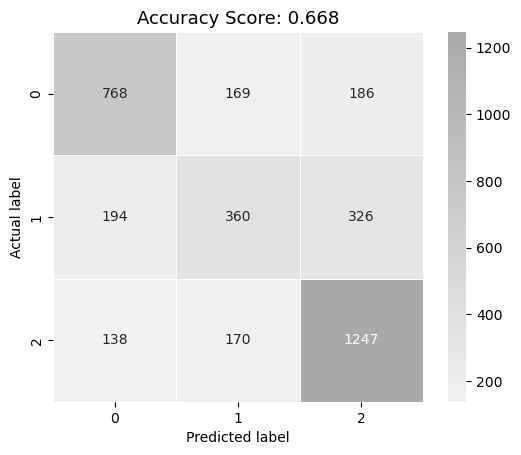

In [481]:
cmap = sns.light_palette("darkgray", as_cmap = True)

sns.heatmap(confusion_matrix, annot = True, fmt = '.0f', cmap = cmap, square = True, linewidths = 0.5)
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
title = 'Accuracy Score: {0}'.format(accuracy) 
plt.title(title, size = 13) 
plt.show()

#### feature importance

In [452]:
logistic_model.coef_

array([[ 3.46808084e-04, -8.20987759e-03, -7.86570087e-02,
        -4.47148710e-04, -8.42994248e-05, -3.63791586e-01],
       [-9.79006225e-03, -3.64824865e-03, -8.65370106e-03,
        -3.42984815e-04,  7.70359863e-05, -5.16842845e-03],
       [ 9.44325416e-03,  1.18581262e-02,  8.73107097e-02,
         7.90133525e-04,  7.26343852e-06,  3.68960014e-01]])

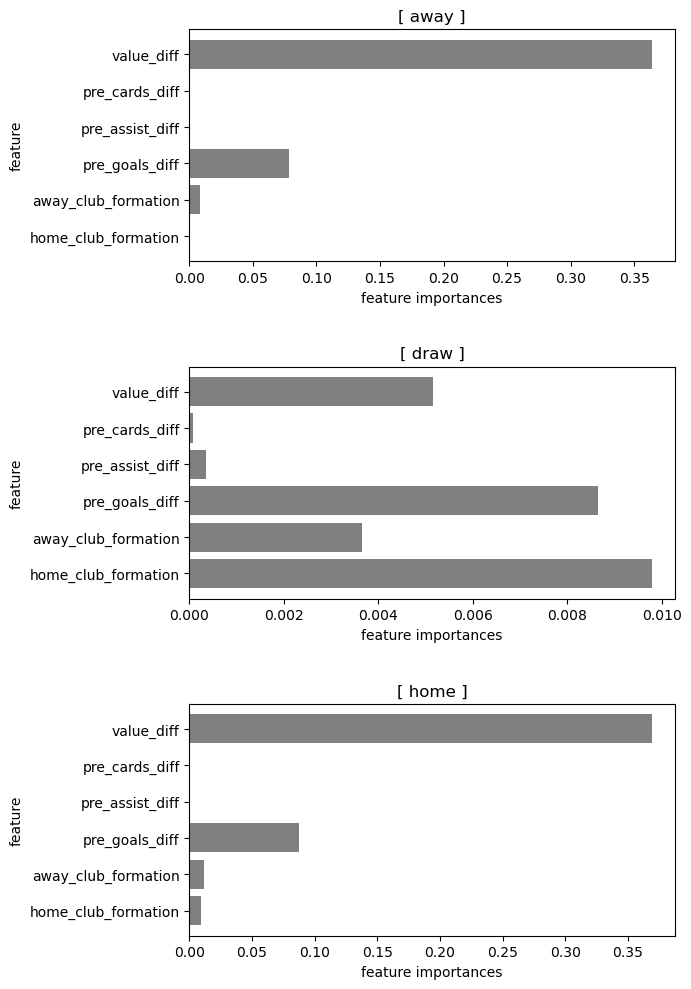

In [482]:
n_feature = x_train.shape[1]
index = np.arange(n_feature)
n_plot = 3
class_list = encoder.classes_
fig, axes = plt.subplots(n_plot, 1, figsize=(7, 10))

for i in range(n_plot):
    axes[i].barh(index, abs(logistic_model.coef_[i]), align = 'center', color = 'gray')
    axes[i].set_yticks(index, x_train.columns)
    axes[i].set_title("[ " + class_list[i] + " ]")
    axes[i].set_xlabel('feature importances', size=10)
    axes[i].set_ylabel('feature', size=10)

plt.tight_layout(h_pad = 3) # plot간 간격 조정
plt.show()


## XGboost

### modeling

In [124]:
pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 3.5 MB/s eta 0:00:29
   ---------------------------------------- 0.5/99.8 MB 6.7 MB/s eta 0:00:15
   ---------------------------------------- 1.0/99.8 MB 7.9 MB/s eta 0:00:13
    --------------------------------------- 1.5/99.8 MB 8.6 MB/s eta 0:00:12
    --------------------------------------- 1.9/99.8 MB 8.8 MB/s eta 0:00:12
    --------------------------------------- 2.4/99.8 MB 8.8 MB/s eta 0:00:12
   - -------------------------------------- 2.8/99.8 MB 8.8 MB/s eta 0:00:11
   - -------------------------------------- 3.2/99.8 MB 8.9 MB/s eta 0:00:11
   - -------------------------------------- 3.7/99.8 MB 9.0 MB/s eta 0:00:11
   - -------------------------------------- 4.2/99.8 MB 9.2 MB/s eta 0:00:11
   - -------------------------------------- 4.6/99.8 MB 9.3 MB/s eta 0:00:11
   -- ------------------------------------- 5.2/99.8 MB 9.4 MB/s eta 0:00:11
   -- 

In [359]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=3, random_state = 2077)

xgb_model.fit(scaled_x_train, y_train.ravel())
xgb_predict_proba = xgb_model.predict_proba(scaled_x_test)
xgb_prediction = xgb_model.predict(scaled_x_test)
xgb_score = xgb_model.score(scaled_x_test, y_test)

### 평가

#### accuracy score

In [430]:
xgb_score = round_f(xgb_score)
xgb_score

0.668

In [431]:
accuracy = accuracy_score(y_test, xgb_prediction)
accuracy = round_f(accuracy)
accuracy

0.668

#### F1 score

In [434]:
from sklearn.metrics import f1_score

xgb_f1_score = f1_score(y_test, xgb_prediction, average = 'weighted')
xgb_f1_score = round_f(xgb_f1_score)
xgb_f1_score

0.66

### visualization

#### confusion matrix

In [436]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

xgb_acc_score = accuracy_score(y_test, xgb_prediction)
xgb_acc_score

0.6675098369870713

In [437]:
confusion_matrix = confusion_matrix(y_true = y_test, y_pred = xgb_prediction)

con_mat = confusion_matrix
accuracy = (con_mat[0,0] + con_mat[1,1] + con_mat[2,2])/len(y_test)
accuracy = round_f(accuracy)
print('accuracy =', accuracy)

accuracy = 0.668


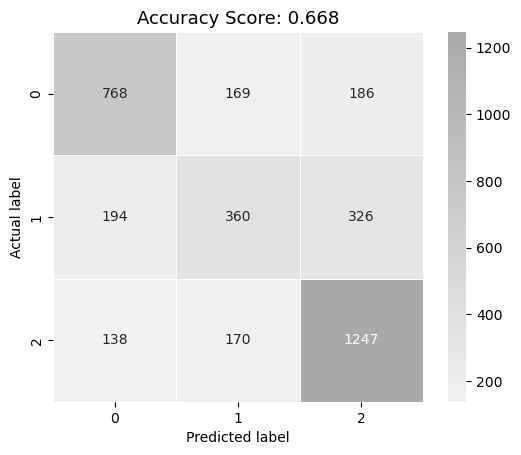

In [483]:
cmap = sns.light_palette("darkgray", as_cmap = True)

sns.heatmap(confusion_matrix, annot = True, fmt = '.0f', cmap = cmap, square = True, linewidths = 0.5)
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
title = 'Accuracy Score: {0}'.format(accuracy) 
plt.title(title, size = 13) 
plt.show()

#### feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

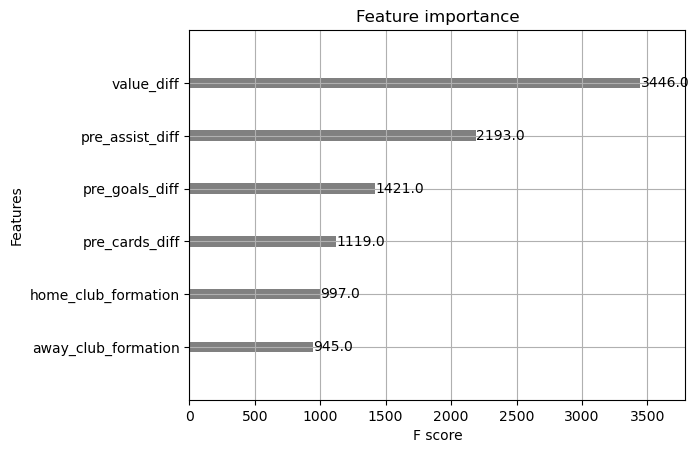

In [497]:
from xgboost import plot_importance

plot_importance(xgb_model, color = 'gray')